# Table of Contents

- [0. Part 0 - Beginning](#0-part-0---beginning-of-the-file)
  - [0.1 Overview](#01-overview)
  - [0.2 Libraries](#02-libraries)


- [I. Part A - Nucleo : One Configuration](#i-part-a---one-configuration)
  - [I.1 File Reading](#i1-file-reading)
  - [I.2 Extracting All Values](#i2-extracting-all-values)
  - [I.3 Illustrating](#i3-illustrating)

- [II. Part B - Nucleo : Comparison of Configurations](#ii-part-b---comparison-of-configurations)
  - [II.1 Parquet Fusion](#ii1-parquet-fusion)
  - [II.2 Verifying Datas](#ii2-verifying-datas)
  - [II.3 Ordering Configurations](#ii3-ordering-configurations)
  - [II.4 Computing Heatmaps](#ii4-computing-heatmaps)
  - [II.5 Plotting Heatmaps](#ii5-plotting-heatmaps)

- [III. Part C - Nucleo : Graphical Representations (1D - 3D)](#iii-part-c---graphical-representations-1d---3d)
  - [III.1 1D](#iii1-1d)
  - [III.2 3D](#iii2-3d)


# 0. Part 0 - Beginning

## 0.1 Overview

This notebook is structured to analyze and visualize simulation results for nucleosome-related configurations. It is divided into several clearly defined parts:

- **Part 0** initializes the environment and loads the necessary libraries.
- **Part A** focuses on a **single configuration**, where relevant data is read, plotted, and analyzed in detail.
- **Part B** compares **multiple configurations** by merging and filtering data from Parquet files, computing key metrics, and generating heatmaps.
- **Part C** provides **graphical representations**, including:
  - A dynamic 3D visualization to capture spatiotemporal behaviors,
  - 1D visual summaries using both single and multiple plots.

Each part is modular and can be almost run independently for clarity and reproducibility. The goal is to facilitate both **exploratory analysis** and **publication-quality figures**.

## 0.2 Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# System and files
import os
import time
import pickle
import logging
from tqdm import tqdm
from datetime import datetime
from pathlib import Path
from collections import defaultdict
from dataclasses import dataclass

# Files and data
import itertools
import collections
import numpy as np
import polars as pl
import fastparquet as fp
import pyarrow.parquet as pq
from dataclasses import fields

# Vizualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tqdm import tqdm

# Maths
from scipy.optimize import curve_fit
from random import *
import math

# Personal
import sys
library_path = Path.home() / "Documents" / "PhD" / "Workspace" / "outline" / "src"
sys.path.append(str(library_path))
import plot_tools as plts

# I. Part A - Nucleo : One configuration

## I.1 File Reading

In [23]:
def ncl_find_parquet_and_load(     
        base_folder = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs",
        **params
) -> pl.DataFrame:
    """
    Search for a parquet file in folder subfolders and check the specified values.
    Then load the parquet file as a Polars DataFrame.

    Args:
        root_directory (str): The root directory path to browse.
        **params: Keyword arguments representing the values to check in folder names.

    Returns:
        pl.DataFrame or None: Returns a Polars DataFrame if a matching file is found, otherwise None.
    """

    # List of subfolders in the root folder
    subdirs = [
        os.path.join(base_folder, d)
        for d in os.listdir(base_folder)
        if os.path.isdir(os.path.join(base_folder, d))
    ]

    # Main loop to iterate over subfolders
    for subdir in tqdm(subdirs, desc="Loading subfiles", unit=" subfiles"):
        for dirpath, dirnames, filenames in os.walk(subdir):  # Browse subfolders
            for dirname in dirnames:
                folder_name = dirname

                # Check if all parameters match in the folder name
                if all(f"{key}_{value}__" in folder_name for key, value in params.items()):
                    # Path of the matching subfolder
                    subdir_path = os.path.join(dirpath, folder_name)
                    print(f"Corresponding subfile found: {subdir_path}")

                    # Look for .parquet files with 'data' in their name
                    for filename in os.listdir(subdir_path):
                        if filename.endswith('.parquet') and 'data' in filename:
                            pq_path = os.path.join(subdir_path, filename)
                            try:
                                # Load data using pyarrow and convert to Polars DataFrame
                                data = pq.read_table(pq_path)
                                df_polars = pl.DataFrame(data)
                                pl.Config.set_tbl_cols(len(df_polars.columns))
                                # Prints
                                # print('Values:', df_polars.columns)
                                # print(df_polars.head())
                                # print('Verification of data availability:', df_polars['times'].to_numpy())
                                print('File loaded and data availables')
                                return df_polars
                            except Exception as e:
                                print("Error loading parquet:", e)
                                return None

    # No matching folders found
    print("No sub-folders match the specified criteria.")
    return None

# Parameters
params = {
    "alpha_choice": "periodic",
    "s": 150,
    "l": 10,
    "bpmin": 0,
    "mu": 400,
    "theta": 50,
    "nt": 10_000,
    "tmax": 100,
    "dt": 1,
    "alphao": 0,
    "alphaf": 1,
    "beta": 0,
    "Lmin": 0,
    "Lmax": 50_000,
    "origin": 10_000,
    "bps": 1,
}

# Call
df_polars = ncl_find_parquet_and_load(**params)

Loading subfiles:   0%|          | 0/2 [00:00<?, ? subfiles/s]

Corresponding subfile found: /home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-01-01_PSMN/data_nucleo_nu_task_12/__alpha_choice_periodic__s_150__l_10__bpmin_0__mu_400__theta_50__nt_10000__tmax_100__dt_1__alphao_0__alphaf_1__beta_0__Lmin_0__Lmax_50000__origin_10000__bps_1__
File loaded and data availables


## I.2 Extracting All Values

In [24]:
@dataclass
class SimulationData:
    # Inputs
    alpha_choice: str
    s: int
    l: int
    bpmin: int
    mu: float
    theta: float
    nt: int
    tmax: float
    dt: float
    times: np.ndarray
    alphao: float
    alphaf: float
    beta: float
    Lmin: int
    Lmax: int
    origin: int
    bps: int

    # Obstacle
    alpha_mean: np.ndarray
    obs_points: np.ndarray
    obs_distrib: np.ndarray
    link_points: np.ndarray
    link_distrib: np.ndarray
    link_view: np.ndarray

    # Probabilities
    p: np.ndarray

    # Results
    results: np.ndarray
    results_mean: np.ndarray
    results_med: np.ndarray
    results_std: np.ndarray
    v_mean: float
    v_med: float

    # Fitting
    vf: float
    vf_std: float
    Cf: float
    Cf_std: float
    wf: float
    wf_std: float

    # First pass times
    bin_fpt: int
    fpt_distrib_2D: np.ndarray
    fpt_number: np.ndarray

    # Time between jumps
    tbj_points: np.ndarray
    tbj_distrib: np.ndarray

    # Instantaneous speeds
    dx_points: np.ndarray
    dx_distrib: np.ndarray
    dx_mean: float
    dx_med: float
    dx_mp: float

    dt_points: np.ndarray
    dt_distrib: np.ndarray
    dt_mean: float
    dt_med: float
    dt_mp: float

    vi_points: np.ndarray
    vi_distrib: np.ndarray
    vi_mean: float
    vi_med: float
    vi_mp: float

    # Last parameters
    alpha_0: float

    # Plot tools
    xt_over_t: np.ndarray
    G: np.ndarray
    bound_low: float
    bound_high: float



def ncl_extract_simulation_data(df_polars: pl.DataFrame) -> SimulationData:
    return SimulationData(
        alpha_choice=df_polars['alpha_choice'][0],
        s=df_polars['s'][0],
        l=df_polars['l'][0],
        bpmin=df_polars['bpmin'][0],
        mu=df_polars['mu'][0],
        theta=df_polars['theta'][0],
        nt=df_polars['nt'][0],
        tmax=df_polars['tmax'][0],
        dt=df_polars['dt'][0],
        times=df_polars['times'][0].to_numpy(),
        alphao=df_polars['alphao'][0],
        alphaf=df_polars['alphaf'][0],
        beta=df_polars['beta'][0],
        Lmin=df_polars['Lmin'][0],
        Lmax=df_polars['Lmax'][0],
        origin=df_polars['origin'][0],
        bps=df_polars['bps'][0],

        alpha_mean=df_polars['alpha_mean'][0].to_numpy(),
        obs_points=df_polars['obs_points'][0].to_numpy(),
        obs_distrib=df_polars['obs_distrib'][0].to_numpy(),
        link_points=df_polars['link_points'][0].to_numpy(),
        link_distrib=df_polars['link_distrib'][0].to_numpy(),
        link_view=df_polars['link_view'][0].to_numpy(),

        p=df_polars['p'][0].to_numpy(),

        results=np.array(df_polars["results"].to_list())[0],
        results_mean=df_polars['results_mean'][0].to_numpy(),
        results_med=df_polars['results_med'][0].to_numpy(),
        results_std=df_polars['results_std'][0].to_numpy(),
        v_mean=df_polars['v_mean'][0],
        v_med=df_polars['v_med'][0],

        vf=df_polars['vf'][0],
        vf_std=df_polars['vf_std'][0],
        Cf=df_polars['Cf'][0],
        Cf_std=df_polars['Cf_std'][0],
        wf=df_polars['wf'][0],
        wf_std=df_polars['wf_std'][0],

        bin_fpt=df_polars['bin_fpt'][0],
        fpt_distrib_2D=np.array(df_polars["fpt_distrib_2D"].to_list())[0],
        fpt_number=df_polars['fpt_number'][0].to_numpy(),

        tbj_points=df_polars['tbj_points'][0].to_numpy(),
        tbj_distrib=df_polars['tbj_distrib'][0].to_numpy(),

        dx_points=df_polars['dx_points'][0].to_numpy(),
        dx_distrib=df_polars['dx_distrib'][0].to_numpy(),
        dx_mean=df_polars['dx_mean'][0],
        dx_med=df_polars['dx_med'][0],
        dx_mp=df_polars['dx_mp'][0],

        dt_points=df_polars['dt_points'][0].to_numpy(),
        dt_distrib=df_polars['dt_distrib'][0].to_numpy(),
        dt_mean=df_polars['dt_mean'][0],
        dt_med=df_polars['dt_med'][0],
        dt_mp=df_polars['dt_mp'][0],

        vi_points=df_polars['vi_points'][0].to_numpy(),
        vi_distrib=df_polars['vi_distrib'][0].to_numpy(),
        vi_mean=df_polars['vi_mean'][0],
        vi_med=df_polars['vi_med'][0],
        vi_mp=df_polars['vi_mp'][0],

        alpha_0=df_polars['alpha_0'][0],

        xt_over_t=df_polars['xt_over_t'][0].to_numpy(),
        G=df_polars['G'][0].to_numpy(),
        bound_low=df_polars['bound_low'][0],
        bound_high=df_polars['bound_high'][0]
    )


# Extracting
sim_data = ncl_extract_simulation_data(df_polars)
print(sim_data.v_mean)
print("Values loaded")

17.396459101873006
Values loaded


## I.3 Illustrating

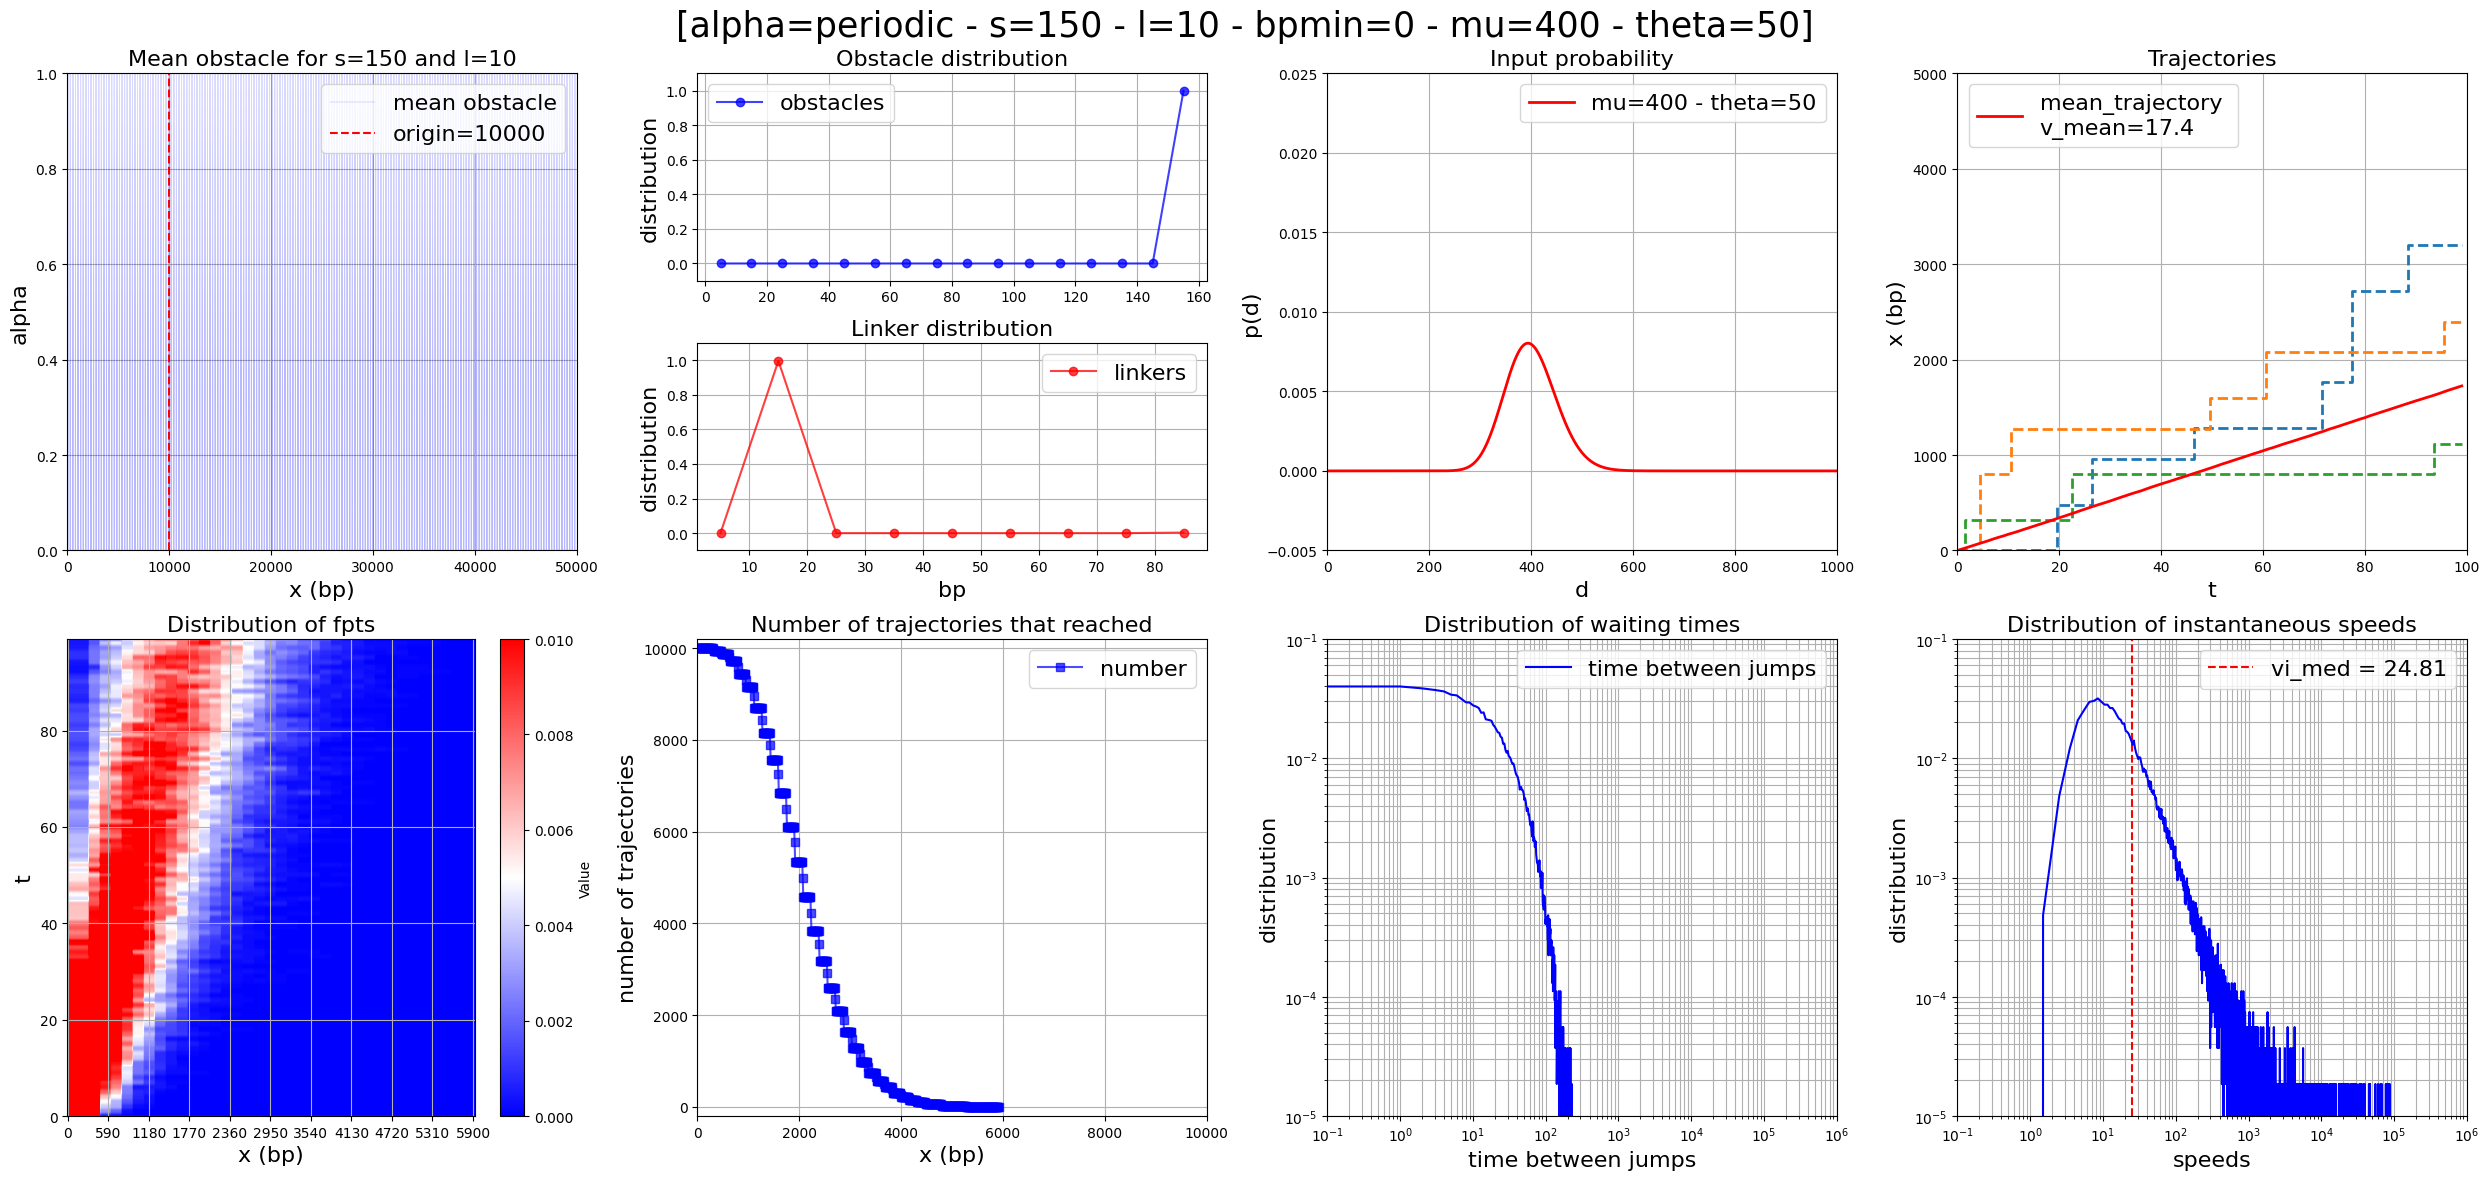

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
axes = axes.flatten()

plot_functions = [
    (plts.ncl_plot_obstacle, (sim_data.s, sim_data.l, sim_data.origin, sim_data.alpha_mean)),
    (plts.ncl_plot_obs_linker_distrib, (sim_data.obs_points, sim_data.obs_distrib, sim_data.link_points, sim_data.link_distrib)),
    (plts.ncl_plot_probabilities, (sim_data.mu, sim_data.theta, sim_data.p)),
    (plts.ncl_plot_trajectories, (sim_data.tmax, sim_data.times, sim_data.results, sim_data.results_mean, sim_data.results_med, sim_data.results_std, sim_data.v_mean, sim_data.v_med)),
    (plts.ncl_plot_fpt_distrib_2d, (sim_data.fpt_distrib_2D, sim_data.tmax, sim_data.bin_fpt)),
    (plts.ncl_plot_fpt_number, (sim_data.nt, sim_data.tmax, sim_data.fpt_number, sim_data.bin_fpt)),
    (plts.ncl_plot_waiting_times, (sim_data.tbj_points, sim_data.tbj_distrib)),
    (plts.ncl_plot_speed_distribution, (sim_data.vi_points, sim_data.vi_distrib, sim_data.vi_mean, sim_data.vi_med, sim_data.vi_mp))
]

for i, (plot_func, args) in enumerate(plot_functions):
    plot_func(*args, ax=axes[i])

plt.suptitle(
    f'[alpha={sim_data.alpha_choice} - s={sim_data.s} - l={sim_data.l} - bpmin={sim_data.bpmin} - mu={sim_data.mu} - theta={sim_data.theta}]',
    fontsize=25
)
plt.tight_layout()
plt.show()

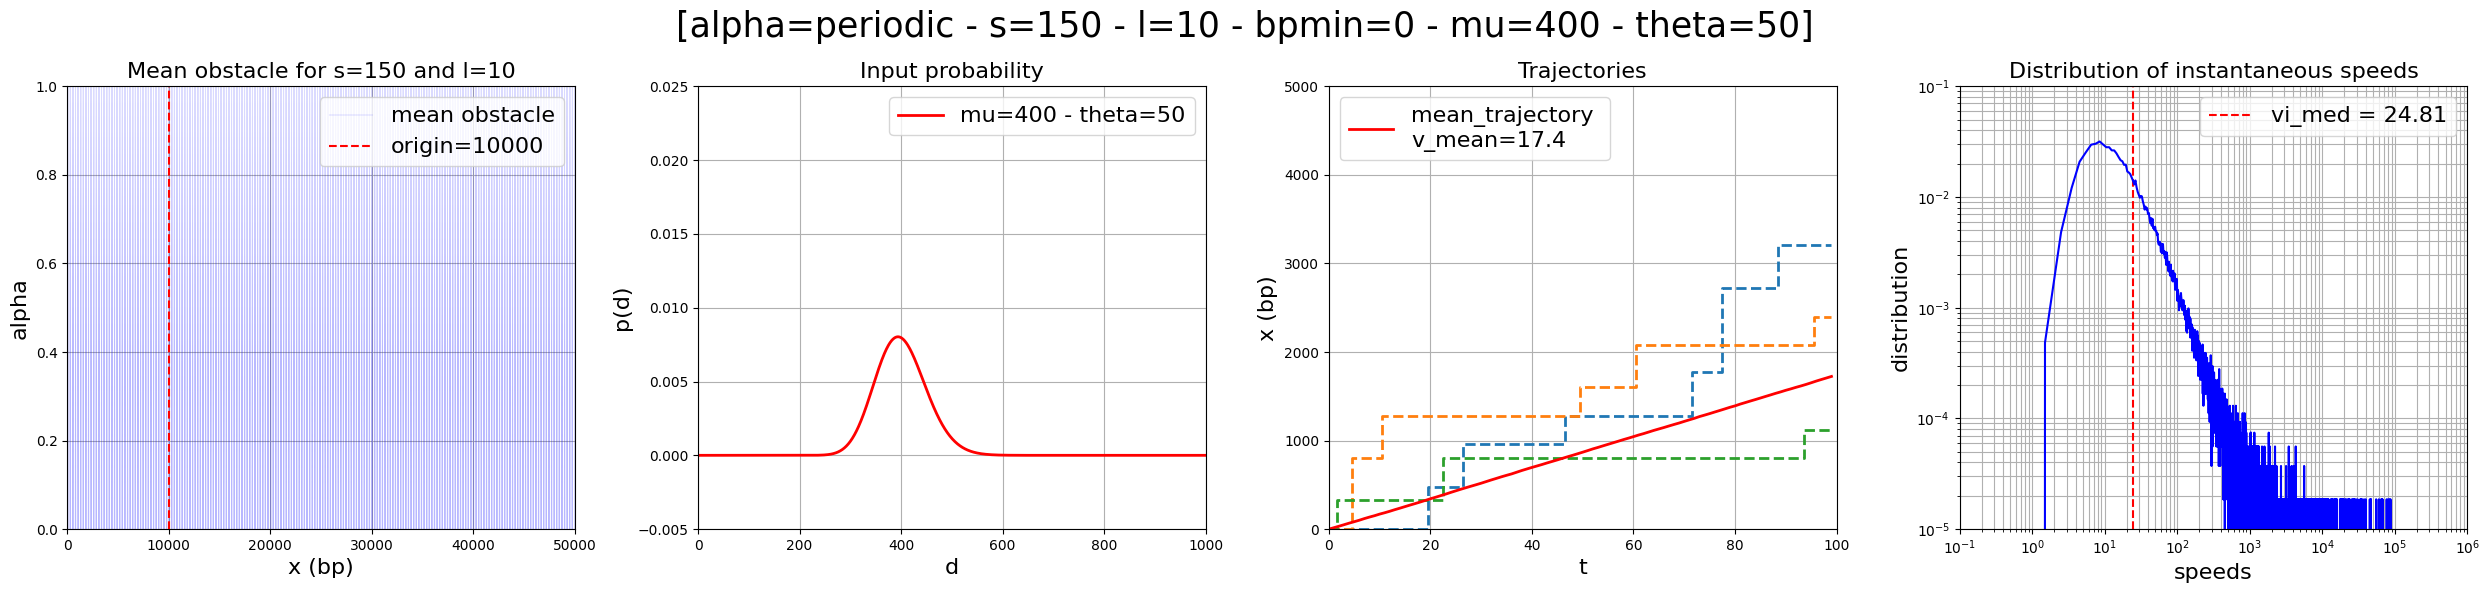

In [26]:
plot_functions = [
    (plts.ncl_plot_obstacle, (sim_data.s, sim_data.l, sim_data.origin, sim_data.alpha_mean)),
    (plts.ncl_plot_probabilities, (sim_data.mu, sim_data.theta, sim_data.p)),
    (plts.ncl_plot_trajectories, (sim_data.tmax, sim_data.times, sim_data.results, sim_data.results_mean, sim_data.results_med, sim_data.results_std, sim_data.v_mean, sim_data.v_med)),
    (plts.ncl_plot_speed_distribution, (sim_data.vi_points, sim_data.vi_distrib, sim_data.vi_mean, sim_data.vi_med, sim_data.vi_mp))
]

fig, axes = plt.subplots(1, len(plot_functions), figsize=(25, 6))
axes = axes.flatten()

for i, (plot_func, args) in enumerate(plot_functions):
    plot_func(*args, ax=axes[i])

plt.suptitle(
    f'[alpha={sim_data.alpha_choice} - s={sim_data.s} - l={sim_data.l} - bpmin={sim_data.bpmin} - mu={sim_data.mu} - theta={sim_data.theta}]',
    fontsize=25
)
plt.tight_layout()
plt.show()

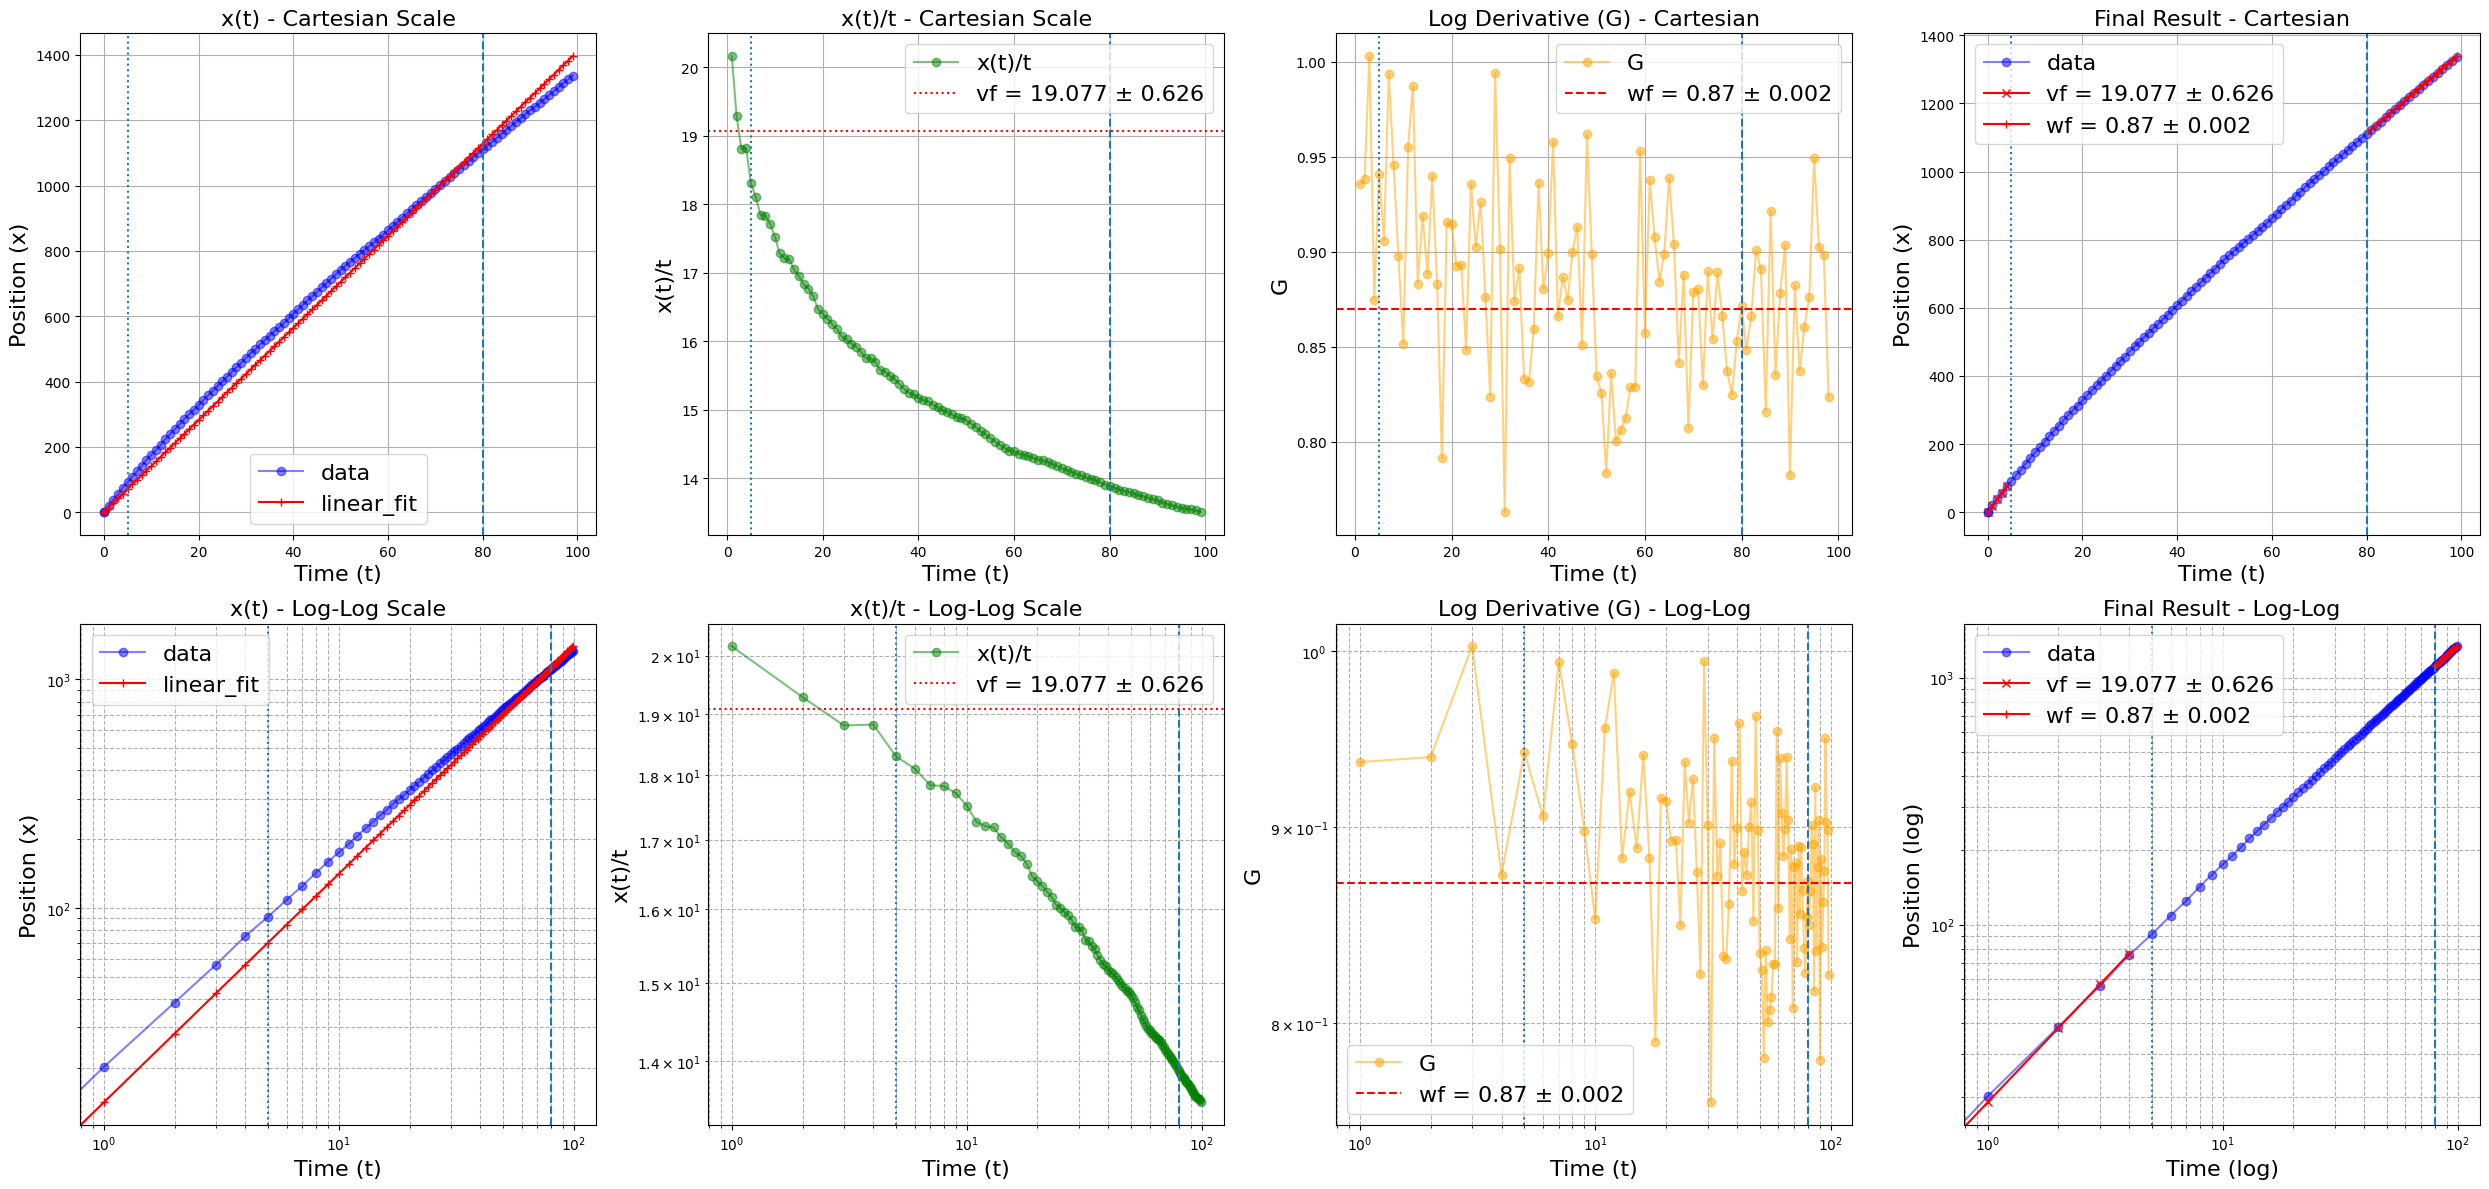

<Figure size 640x480 with 0 Axes>

In [7]:
plts.ncl_plot_fitting_summary(
    sim_data.times,
    sim_data.results_mean,
    sim_data.v_mean,
    sim_data.xt_over_t,
    sim_data.G,
    sim_data.vf,
    sim_data.vf_std,
    sim_data.Cf,
    sim_data.Cf_std,
    sim_data.wf,
    sim_data.wf_std,
    bound_low=sim_data.bound_low,
    bound_high=sim_data.bound_high,
    rf=3,
    text_size=16,
    ax=None
)

plt.tight_layout()
plt.show()

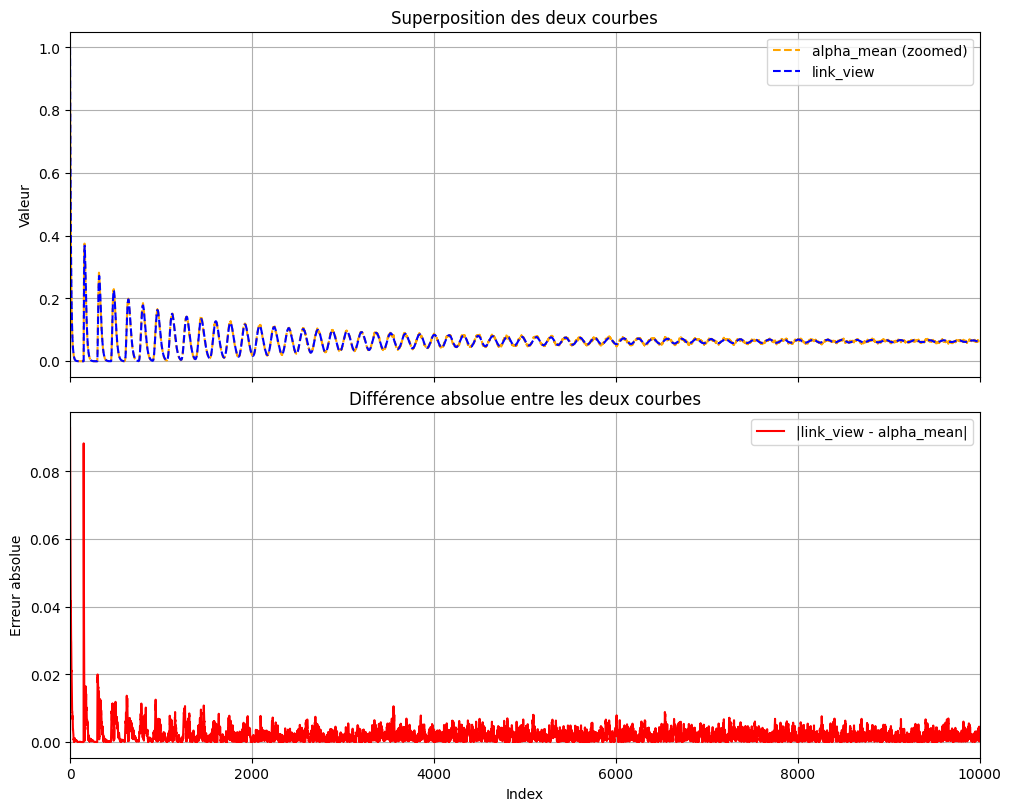

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True, constrained_layout=True)

# 1. Superposition des deux courbes
axes[0].plot(sim_data.alpha_mean[:len(sim_data.link_view)], label="alpha_mean (zoomed)", ls="--", color="orange")
axes[0].plot(sim_data.link_view, label="link_view", ls="--", color="blue")
axes[0].set_xlim(0, 10000)
axes[0].set_ylabel("Valeur")
axes[0].set_title("Superposition des deux courbes")
axes[0].legend()
axes[0].grid(True)

# 2. Différence absolue point à point
diff = np.abs(sim_data.link_view - sim_data.alpha_mean[:len(sim_data.link_view)])
axes[1].plot(diff, label="|link_view - alpha_mean|", color="red")
axes[1].set_xlim(0, 10000)
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Erreur absolue")
axes[1].set_title("Différence absolue entre les deux courbes")
axes[1].legend()
axes[1].grid(True)

plt.show()

# TESTS

In [44]:
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
plt.rcParams['font.size'] = 16


def sinusoid(t, A, omega, phi):
    return A * np.sin(omega * t + phi)

working_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "ncl_test_0"
os.chdir(working_path)

df_work = pl.DataFrame()
df_work = pl.concat([pl.read_parquet(file) for file in working_path.rglob("*.parquet") if file.is_file()])
# print(df_work)

all_peaks = []


plt.figure(figsize=(8,6))
for row in df_work.iter_rows(named=True):

    # Extracting datas
    l = row["l"]
    s = row["s"]
    alphaf = row["alphaf"]
    alphao = row["alphao"]
    link_view = row["link_view"]
    label = f"l={row['l']}"
    norm = (s * alphao + alphaf * l) / (s + l)
    data = np.divide(link_view, norm)

    # Calculating sinusoid factors
    x = np.arange(0, len(data), 1)
    popt, _ = curve_fit(sinusoid, x, data)
    A_fit, omega_fit, phi_fit = popt

    # Getting the local maximas
    peaks, _ = find_peaks(data, distance=100)
    all_peaks.append(peaks)
    
    # Plotting
    plt.plot(data, label=f"{label} : y = {A_fit:.2f} sin({omega_fit:.2f} x + {phi_fit:.2f})")
    plt.scatter(peaks, data[peaks], color="red", marker="x")

    
plt.xlim([0, 3000])
plt.ylim([0, 10])
plt.xlabel("position in bp")
plt.ylabel("phase count")
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
for i in range(0, len(all_peaks)):
    plt.plot(np.arange(0,10), all_peaks[i][0:10], label=f"{i}", marker="o")
plt.xlabel("peak count")
plt.ylabel("peak position")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/ncl_test_0'

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import polars as pl
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Définir le modèle sinusoidal
def sinusoid(t, A, omega, phi):
    return A * np.sin(omega * t + phi)

# Chargement des données
working_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "ncl_test_0"
os.chdir(working_path)
df_work = pl.concat([pl.read_parquet(file) for file in working_path.rglob("*.parquet") if file.is_file()])

all_peaks = []

# Création de la figure principale
fig, ax = plt.subplots(figsize=(8,6))  # 🔧 Figure + Axes

for row in df_work.iter_rows(named=True):

    l = row["l"]
    s = row["s"]
    alphaf = row["alphaf"]
    alphao = row["alphao"]
    link_view = row["link_view"]
    label = f"l={l}"
    norm = (s * alphao + alphaf * l) / (s + l)
    data = np.divide(link_view, norm)

    x = np.arange(0, len(data), 1)
    popt, _ = curve_fit(sinusoid, x, data)
    A_fit, omega_fit, phi_fit = popt

    peaks, _ = find_peaks(data, distance=100)
    all_peaks.append(peaks)
    
    ax.plot(data, label=f"{label} : y = {A_fit:.2f} sin({omega_fit:.2f} x + {phi_fit:.2f})")
    # ax.scatter(peaks, data[peaks], color="red", marker="x")

# Légendes principales
ax.set_xlim([0, 3000])
ax.set_ylim([0, 10])
ax.set_xlabel("position in bp")
ax.set_ylabel("phase count")
ax.legend(loc="upper left", fontsize=8)

# 🔍 Inset plot : zoom sur un pic
ax_inset = inset_axes(ax, width="50%", height="50%", loc="upper right", borderpad=2)

# Exemple : zoomer sur la première courbe si elle existe
if len(all_peaks) > 0:
    for i in range(0, len(all_peaks)):
        ax_inset.plot(np.arange(0,10), all_peaks[i][0:10], label=f"{i}", marker="o")
        ax_inset.set_xlabel("peak count")
        ax_inset.set_ylabel("peak position")
        # ax_inset.set_xticks([])
        # ax_inset.set_yticks([])
        ax_inset.legend(fontsize=8)

# plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/ncl_test_0'

# II. Part B - Comparison of Configurations

## II.1 Parquet Fusion

In [7]:
# --- Dialog box to merge all the parquet files together --- #

def ask_confirmation_input():
    response = input("Are you sure you want to merge all the parquet files? (Yes/No): ")
    if response != "Yes":
        raise RuntimeError("Stopped by the user.")

ask_confirmation_input()
print("Ready.")

Ready.


In [53]:
# --- Big fusion --- #

def ncl_merging_parquet_files(root_directory, nt, tmax, dt, alphao, alphaf, beta, Lmin, Lmax, origin, bps):
    """
    Merges all the .parquet files from our simulations while filtering only columns of types str, i64, and f64.

    Args:
        root_directory (str): Root directory containing subfolders.
        L_max (int): Filter parameter for subfolders.
        n_t (int): Filter parameter for subfolders.

    Returns:
        None
    """

    os.chdir(root_directory)  # Navigate to root directory to avoid unwanted paths
    print("Launched at:", os.getcwd())

    # Main result storage
    dataframes = []

    # List of subfolders to check in the root folder
    subdirs = [os.path.join(root_directory, d) for d in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, d))]

    # Main loop
    for subdir in tqdm(subdirs, desc="Loading subfiles", unit=" subfiles"):
        for dirpath, dirnames, filenames in os.walk(subdir):
            for dirname in dirnames:
                folder_name = dirname
                # Verification
                if (f"nt_{nt}_" in folder_name and 
                    f"tmax_{tmax}" in folder_name and 
                    f"dt_{dt}" in folder_name and 
                    f"alphao_{alphao}" in folder_name and 
                    f"alphaf_{alphaf}" in folder_name and 
                    f"beta_{beta}" in folder_name and 
                    f"Lmin_{Lmin}" in folder_name and 
                    f"Lmax_{Lmax}" in folder_name and 
                    f"origin_{origin}" in folder_name and 
                    f"bps_{bps}" in folder_name 
                    ):
                    # Path of the corresponding subfolder
                    subdir_path = os.path.join(dirpath, folder_name)

                    for filename in os.listdir(subdir_path):
                        if filename.endswith('.parquet') and 'data' in filename:
                            pq_path = os.path.join(subdir_path, filename)

                            try:
                                # Read the parquet file
                                df_parquet = pl.read_parquet(pq_path)
                                df_columns = df_parquet.columns
                                class_columns = set(f.name for f in fields(SimulationData))

                                if collections.Counter(df_columns) == collections.Counter(class_columns):

                                    # Filter only columns of type str, i64, or f64
                                    filtered_df = df_parquet.select([
                                        col for col, dtype in zip(df_parquet.columns, df_parquet.dtypes)
                                        if dtype in [pl.Utf8, pl.Int64, pl.Float64]
                                    ])
                                    
                                    dataframes.append(filtered_df)

                            except Exception as e:
                                print(f"Error loading Parquet file: {e}")
    
    # Concatenate and write the final result
    if dataframes:
        merged_df = pl.concat(dataframes)
        last_address = f'{root_directory}/ncl_output.parquet'
        merged_df.write_parquet(last_address)
        print(f"All files merged and saved to {last_address}.")
    else:
        print("No Parquet files found that match the criteria.")

    return None


# --- Launching --- #
root = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN"
ncl_merging_parquet_files(root_directory=root, nt=10000, tmax=100, dt=1, alphao=0, alphaf=1, beta=0, Lmin=0, Lmax=50000, origin=10000, bps=1)

Launched at: /home/nicolas/Documents/PhD/Workspace/nucleo/outputs/nucleo_folder_Xnfs


Loading subfiles:   0%|          | 0/96 [00:00<?, ? subfiles/s]

Loading subfiles:   0%|          | 0/96 [00:07<?, ? subfiles/s]


KeyboardInterrupt: 

## II.2 Verifying Datas

In [9]:
# Getting the file with Polars and performing verifications
def ncl_getting_main_file_and_verification(
    df: pl.DataFrame,
    nt: int = 10000,
    tmax: int = 100,
    dt: int = 1,
    alphao: float = 0.0,
    alphaf: float = 1.0,
    beta: float = 0.0,
    Lmin: int = 0,
    Lmax: int = 50_000,
    origin: int = 10_000,
    bps: int = 1
) -> pl.DataFrame:
    """
    Filters a Polars DataFrame based on specific criteria.

    Args:
        df (pl.DataFrame): The input DataFrame containing the dataset.
        nt (int, default=1000): Number of time steps in the simulation.
        tmax (int, default=100000): Maximum simulation time.
        dt (int): Time step interval.
        alphao (float, default=0.5): Initial alpha value.
        alphaf (float, default=0.5): Final alpha value.
        beta (float, default=1.0): Beta value used in the simulation.
        Lmin (int, default=0): Minimum linker length.
        Lmax (int, default=500): Maximum linker length.
        origin (int, default=0): Origin value used in the setup.
        bps (int, default=10): Base pairs per step.

    Returns:
        pl.DataFrame: The filtered DataFrame based on the given parameters.
    """

    selected_columns = {
        "alpha_choice", "s", "l", "bpmin", 
        "mu", "theta", 
        "nt", "tmax", "dt", "times", 
        "alphao", "alphaf", "beta",
        "Lmin", "Lmax", "origin", "bps",
        
        "v_mean", "v_med", 
        "vf", "Cf", "wf", "vf_std", "Cf_std", "wf_std", 
        "vi_mean", "vi_med", "vi_mp",
    }

    # Select only the required columns
    filtered_columns = [col for col in df.columns if col in selected_columns]
    filtered_df = df.select(filtered_columns)

    # Verify that all rows have 's' equal to 150
    if (filtered_df["s"] == 150).all():
        print("All rows have s = 150.")
    else:
        print("Some rows do not have s = 150.")
        print(filtered_df.filter(pl.col("s") != 150))

    # Apply filtering based on predefined conditions
    filtered_df = (
        filtered_df
        .filter(pl.col("nt") == nt)
        .filter(pl.col("tmax") == tmax)
        .filter(pl.col("dt") == dt)
        .filter(pl.col("alphao") == alphao)
        .filter(pl.col("alphaf") == alphaf)
        .filter(pl.col("beta") == beta)
        .filter(pl.col("Lmin") == Lmin)
        .filter(pl.col("Lmax") == Lmax)
        .filter(pl.col("origin") == origin)
        .filter(pl.col("bps") == bps)
    )

    return filtered_df


# Reading it for further manipulations
main_file_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN" / "ncl_output.parquet"
data = pq.read_table(main_file_path)
df_polars = pl.DataFrame(data)

# Loading file + Filtering
df_pl_main = ncl_getting_main_file_and_verification(df_polars)
print('The df_polars containing the int and floats for all our simulations :\nTotal shape :',df_pl_main.shape, '\nQuick print and shape :', df_pl_main.head(5))

All rows have s = 150.
The df_polars containing the int and floats for all our simulations :
Total shape : (131300, 27) 
Quick print and shape : shape: (5, 27)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ alp ┆ s   ┆ l   ┆ bpm ┆ mu  ┆ the ┆ nt  ┆ tma ┆ dt  ┆ alp ┆ alp ┆ bet ┆ Lmi ┆ Lma ┆ ori ┆ bps ┆ v_m ┆ v_m ┆ vf  ┆ Cf  ┆ wf  ┆ vf_ ┆ Cf_ ┆ wf_ ┆ vi_ ┆ vi_ ┆ vi_ │
│ ha_ ┆ --- ┆ --- ┆ in  ┆ --- ┆ ta  ┆ --- ┆ x   ┆ --- ┆ hao ┆ haf ┆ a   ┆ n   ┆ x   ┆ gin ┆ --- ┆ ean ┆ ed  ┆ --- ┆ --- ┆ --- ┆ std ┆ std ┆ std ┆ mea ┆ med ┆ mp  │
│ cho ┆ i64 ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ i64 ┆ --- ┆ --- ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ --- ┆ --- ┆ n   ┆ --- ┆ --- │
│ ice ┆     ┆     ┆ i64 ┆     ┆ i64 ┆     ┆ i64 ┆     ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆     ┆ f64 ┆ f64 ┆     ┆     ┆     ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ f64 │
│ --- ┆     ┆     ┆ 

## II.3 Ordering Configurations

In [10]:
# Creating an order for the configurations
def ncl_df_polar_ordering(data_frame): 
    """We're extracting the different configurations of modeling and ordering them for a proper representation

    Args:
        data_frame (df): filtered data frame

    Returns:
        sorted_combinations_configs: the configurations
    """

    df = data_frame                             # More convinient
    filtered_combinations = df.filter(
        ~(
            ((pl.col("alpha_choice") == 'periodic') | (pl.col("alpha_choice") == 'constant_mean')) &
            (pl.col("bpmin") == 5)
        )
    )

    # Getting the unique combinations of 's', 'l', 'bpmin' and 'alpha_choice'
    unique_combinations = filtered_combinations.select(['s', 'l', 'bpmin', 'alpha_choice']).unique()

    # Ordering it by alpha_choice in priority
    alpha_order = pl.when(pl.col("alpha_choice") == 'constant_mean').then(1)\
                    .when(pl.col("alpha_choice") == 'periodic').then(2)\
                    .when(pl.col("alpha_choice") == 'nt_random').then(3)\
                    .otherwise(4)
    unique_combinations = unique_combinations.with_columns(
        alpha_order.alias("alpha_order")
    )

    # Ordering by 'alpha_order', then by 'bpmin', and finally by 'l' with l=10 prioritazed
    sorted_combinations = unique_combinations.sort(by=['alpha_order', 'bpmin', 'l'])

    # Suppressing the temporary column 'alpha_order'
    sorted_combinations = sorted_combinations.drop('alpha_order')

    # Convertiing it into a list of dict
    sorted_combinations_configs = sorted_combinations.rows()
    sorted_combinations_configs = [
        {"s": row[0], "l": row[1], "bpmin": row[2], "alpha_choice": row[3]} 
        for row in sorted_combinations_configs
    ]

    # Print
    for config in sorted_combinations_configs:
        print(config)

    return sorted_combinations_configs


# Getting unique combinations
print('\nConfigurations :')
sorted_combinations_configs = ncl_df_polar_ordering(df_pl_main)


Configurations :
{'s': 150, 'l': 10, 'bpmin': 0, 'alpha_choice': 'constant_mean'}
{'s': 150, 'l': 10, 'bpmin': 0, 'alpha_choice': 'periodic'}
{'s': 150, 'l': 5, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 10, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 15, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 20, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 25, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 50, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 100, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 150, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 10, 'bpmin': 5, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 10, 'bpmin': 10, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 10, 'bpmin': 15, 'alpha_choice': 'nt_random'}


## II.4 Computing Heatmaps

In [9]:
# --- Dialog box to compute the 2D heatmap --- #

def ask_confirmation_input():
    response = input("Are you sure you want to compute the 2D heatmap ? (Yes/No): ")
    if response != "Yes":
        raise RuntimeError("Stopped by the user.")

ask_confirmation_input()
print("Ready.")

RuntimeError: Stopped by the user.

In [17]:
# --- Creating the main polar file --- #


def ncl_compute_heatmap_data(df: pl.DataFrame, config_list: list, speed_cols: list, root: str) -> dict:
    """
    Computes and stores heatmap data for each configuration and speed column.
    Linear speeds are getting normalized by the theoretical values of constant_mean scenario.

    Args:
        df (pl.DataFrame): Data containing multiple speed configurations.
        config_list (list): List of configuration dictionaries.
        speed_cols (list): List of speed columns to process.

    Returns:
        dict: Nested dictionary {config_idx -> {speed_col -> heatmap_data, config_metadata}}.
    """

    all_data_raw = {}
    all_data_norm_mu = {}
    all_data_norm_th = {}

    for idx, config in tqdm(enumerate(config_list), total=len(config_list), desc="Computing heatmaps"):

        df_filtered = df.filter(
            (pl.col('s') == config['s']) &
            (pl.col('l') == config['l']) &
            (pl.col('bpmin') == config['bpmin']) &
            (pl.col('alpha_choice') == config['alpha_choice'])
        )

        if df_filtered.is_empty():
            print(f"No data for config {config}")
            continue

        mu_values = df_filtered['mu'].unique().sort()
        theta_values = df_filtered['theta'].unique().sort()

        # Store configuration metadata (init both dicts)
        meta = {
            "mu_values": mu_values,
            "theta_values": theta_values,
            "config": config
        }

        all_data_raw[idx] = dict(meta)
        all_data_norm_mu[idx] = dict(meta)
        all_data_norm_th[idx] = dict(meta)

        # Loop on data
        for speed_col in speed_cols:
            heatmap_raw = []
            heatmap_norm_mu = []
            heatmap_norm_th = []

            for theta in tqdm(theta_values, desc=f"Processing theta for config {idx}", leave=False):
                data_raw = []
                data_norm_mu = []
                data_norm_th = []

                for mu in mu_values:
                    values = df_filtered.filter((pl.col('mu') == mu) & (pl.col('theta') == theta))[speed_col].mean()
                    norm_mu = mu
                    norm_th = ((df_filtered['alphao'][0] * df_filtered['s'][0] +
                                df_filtered['alphaf'][0] * df_filtered['l'][0]) /
                                (df_filtered['l'][0] + df_filtered['s'][0])) * mu

                    if speed_col in {'v_mean', 'vi_med', 'vi_mp', 'vf'}:
                        data_raw.append(values if values is not None else 0)
                        data_norm_mu.append(values / norm_mu if values is not None else 0)
                        data_norm_th.append(values / norm_th if values is not None else 0)
                       
                    elif speed_col in {'Cf', 'wf'}:
                        data_raw.append(values if values is not None else 0)
                        data_norm_mu.append(values if values is not None else 0)
                        data_norm_th.append(values if values is not None else 0)

                heatmap_raw.append(data_raw)
                heatmap_norm_mu.append(data_norm_mu)
                heatmap_norm_th.append(data_norm_th)

            all_data_raw[idx][speed_col] = np.array(heatmap_raw)
            all_data_norm_mu[idx][speed_col] = np.array(heatmap_norm_mu)
            all_data_norm_th[idx][speed_col] = np.array(heatmap_norm_th)

    # Saving datas
    path_raw  = os.path.join(root, "hmp_nucleo_raw.pkl")
    path_norm_mu = os.path.join(root, "hmp_nucleo_nmu.pkl")
    path_norm_th = os.path.join(root, "hmp_nucleo_nth.pkl")

    with open(path_raw, "wb") as f:
        pickle.dump(all_data_raw, f)
    with open(path_norm_mu, "wb") as f:
        pickle.dump(all_data_norm_mu, f)
    with open(path_norm_th, "wb") as f:
        pickle.dump(all_data_norm_th, f)

    print("Files written at :", path_raw, "-", path_norm_mu, "-", path_norm_th)
    return None


# --- Compute and Save Data --- #
root = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN"
speed_columns = ['v_mean', 'vi_med', 'vi_mp', 'vf', 'Cf', 'wf']
ncl_compute_heatmap_data(df_pl_main, sorted_combinations_configs, speed_columns, root)

Computing heatmaps:   0%|          | 0/13 [00:00<?, ?it/s]

Computing heatmaps: 100%|██████████| 13/13 [10:26<00:00, 48.19s/it]

Files written at : /home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-01-01_PSMN/ncl_hm_raw.pkl - /home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-01-01_PSMN/ncl_hm_nmu.pkl - /home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-01-01_PSMN/ncl_hm_nth.pkl


## II.5 Plotting Heatmaps

Plotting heatmaps: 100%|██████████| 13/13 [00:01<00:00, 11.70it/s]


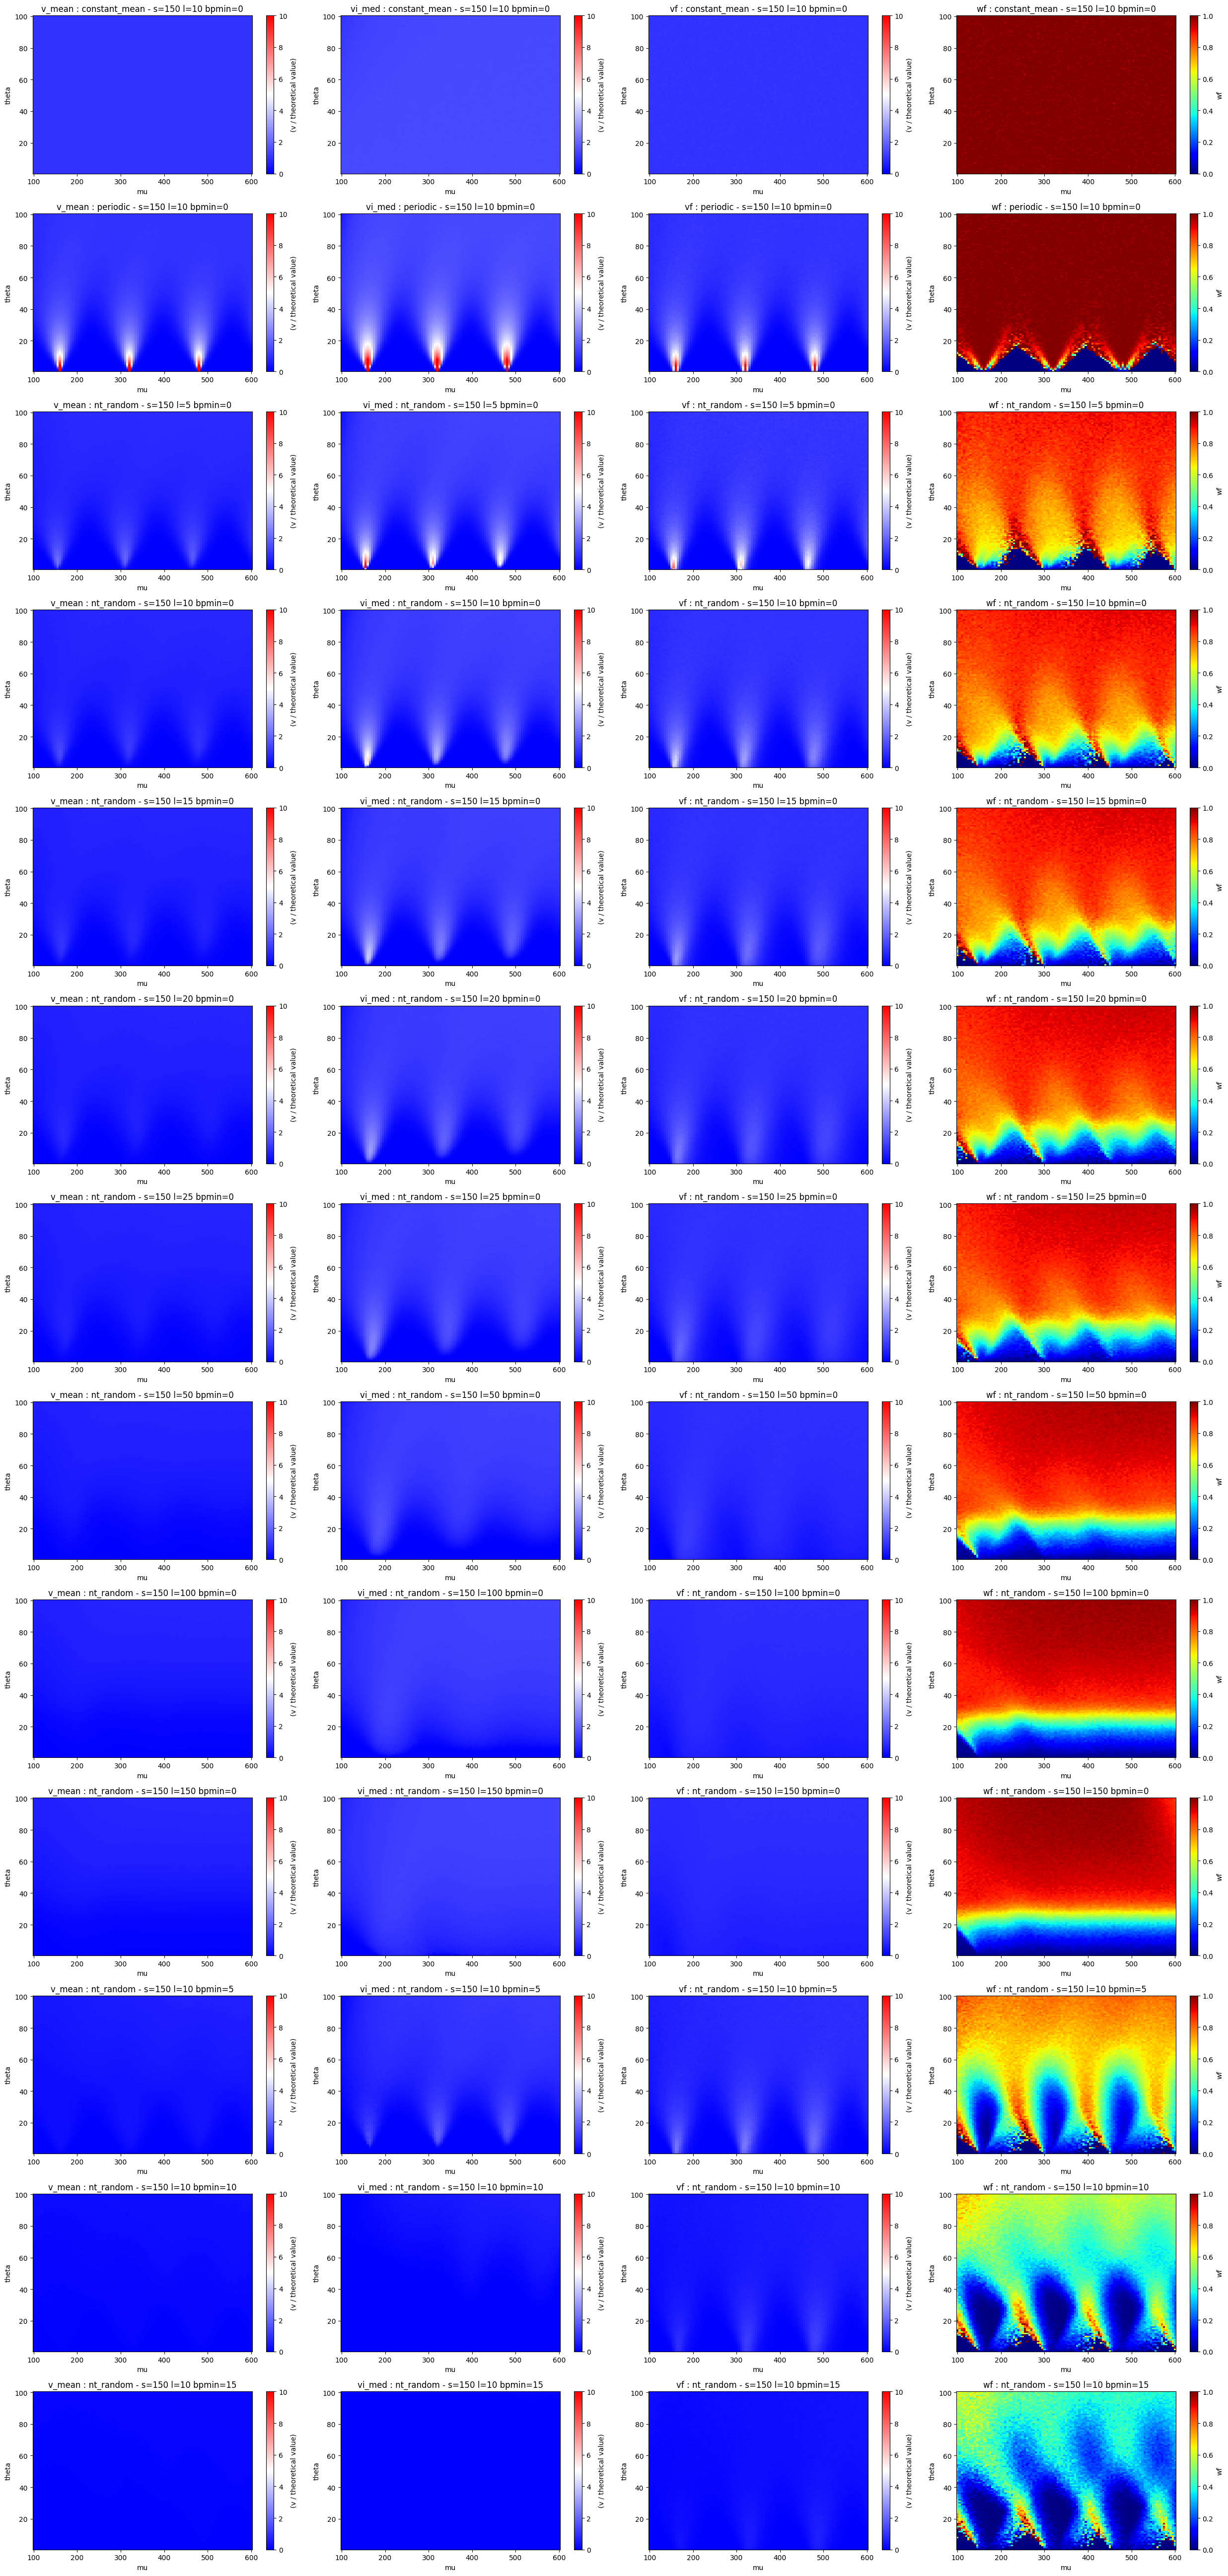

In [30]:
def ncl_plot_precomputed_heatmaps(speed_cols, root = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN", type_of_data="raw", plot_log2=False):
    """
    Plots heatmaps of either raw or log2-transformed values depending on the variable:
    - log2 + bwr for all except wf
    - linear + jet for wf

    Data are already normalized by the theoretical values of the constant_value scenario !

    """

    if plot_log2:
        title_bar_mini = "log₂ "
    else:
        title_bar_mini = ""

    if type_of_data not in ["raw", "norm_mu", "norm_th"]:
        raise ValueError ("No such type_of_data possible to plot.")

    if type_of_data == "raw":
        main_file_path = root / "hmp_nucleo_raw.pkl"
        title_bar = title_bar_mini + "v"
        if plot_log2:
            vmin, vmax = -2, 10
        else :
            vmin, vmax = 0, 50

    elif type_of_data == "norm_mu":
        main_file_path = root / "hmp_nucleo_nmu.pkl"
        title_bar = title_bar_mini + "(v / mean value)"
        if plot_log2:
            vmin, vmax = -1, 0.010
        else:
            vmin, vmax = 0, 0.50

    elif type_of_data == "norm_th":
        main_file_path = root / "hmp_nucleo_nth.pkl"
        title_bar = title_bar_mini + "(v / theoretical value)"
        if plot_log2:
            vmin, vmax = -2, 2
        else:
            vmin, vmax = 0, 10

    with open(main_file_path, "rb") as f:
        computed_data = pickle.load(f)

    n_combinations = len(computed_data)
    fig, axes = plt.subplots(nrows=n_combinations, ncols=len(speed_cols), figsize=(25, 4 * n_combinations))
    axes = np.atleast_2d(axes)

    for idx, (key, config_data) in enumerate(tqdm(computed_data.items(), total=n_combinations, desc="Plotting heatmaps")):
        mu_values = config_data["mu_values"]
        theta_values = config_data["theta_values"]
        config = config_data["config"]

        for col_idx, speed_col in enumerate(speed_cols):
            ax = axes[idx, col_idx]
            data = config_data[speed_col]

            if speed_col == "wf":
                cmap = 'jet'
                wmin = 0
                wmax = 1
                data_to_plot = data
                c = ax.pcolormesh(mu_values, theta_values, data_to_plot, cmap=cmap, vmin=wmin, vmax=wmax)
                cbar = plt.colorbar(c, ax=ax)
                cbar.set_label(f"{speed_col}")

            else:
                cmap = 'bwr'
                if plot_log2: 
                    data_to_fix = np.log2(data, dtype=float)
                    data_to_plot = np.nan_to_num(data_to_fix, nan=0.0)
                else:
                    data_to_plot = data
                c = ax.pcolormesh(mu_values, theta_values, data_to_plot, cmap=cmap, vmin=vmin, vmax=vmax)
                cbar = plt.colorbar(c, ax=ax)
                cbar.set_label(title_bar)

            ax.set_title(f"{speed_col} : {config['alpha_choice']} - s={config['s']} l={config['l']} bpmin={config['bpmin']}")
            ax.set_xlabel("mu")
            ax.set_ylabel("theta")

    plt.tight_layout()
    plt.show()


# --- Load Data and Plot --- #
ncl_plot_precomputed_heatmaps(
    # speed_cols=["v_mean", "vi_med", "vi_mp", "vf", "wf"]
    speed_cols=["v_mean", "vi_med", "vf", "wf"],
    type_of_data = "norm_th",
    plot_log2=False
)

# III. Part C - Graphical Representations (1D - 3D)

## III.1 1D

In [14]:
# Sous forme de fonction finale

# Datas
work_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN" / "ncl_output.parquet"
work_data = pq.read_table(work_path)
work_df = pl.DataFrame(work_data)

# Loading file + Filtering
work_df = ncl_getting_main_file_and_verification(work_df)
print("Values loaded by DataFrame polars.")

# Configurations
print('\nConfigurations :')
work_configs = ncl_df_polar_ordering(work_df)

All rows have s = 150.
Values loaded by DataFrame polars.

Configurations :
{'s': 150, 'l': 10, 'bpmin': 0, 'alpha_choice': 'constant_mean'}
{'s': 150, 'l': 10, 'bpmin': 0, 'alpha_choice': 'periodic'}
{'s': 150, 'l': 5, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 10, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 15, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 20, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 25, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 50, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 100, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 150, 'bpmin': 0, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 10, 'bpmin': 5, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 10, 'bpmin': 10, 'alpha_choice': 'nt_random'}
{'s': 150, 'l': 10, 'bpmin': 15, 'alpha_choice': 'nt_random'}


Working on: {'s': 150, 'l': 10, 'bpmin': 0, 'alpha_choice': 'nt_random'} 
With: output=vi_med - fx_name=theta - fx_value=50
shape: (1, 27)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ alp ┆ s   ┆ l   ┆ bpm ┆ mu  ┆ the ┆ nt  ┆ tma ┆ dt  ┆ alp ┆ alp ┆ bet ┆ Lmi ┆ Lma ┆ ori ┆ bps ┆ v_m ┆ v_m ┆ vf  ┆ Cf  ┆ wf  ┆ vf_ ┆ Cf_ ┆ wf_ ┆ vi_ ┆ vi_ ┆ vi_ │
│ ha_ ┆ --- ┆ --- ┆ in  ┆ --- ┆ ta  ┆ --- ┆ x   ┆ --- ┆ hao ┆ haf ┆ a   ┆ n   ┆ x   ┆ gin ┆ --- ┆ ean ┆ ed  ┆ --- ┆ --- ┆ --- ┆ std ┆ std ┆ std ┆ mea ┆ med ┆ mp  │
│ cho ┆ i64 ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ i64 ┆ --- ┆ --- ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ --- ┆ --- ┆ n   ┆ --- ┆ --- │
│ ice ┆     ┆     ┆ i64 ┆     ┆ i64 ┆     ┆ i64 ┆     ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆     ┆ f64 ┆ f64 ┆     ┆     ┆     ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ f64 │
│ --- ┆     ┆     ┆     ┆     ┆     ┆    

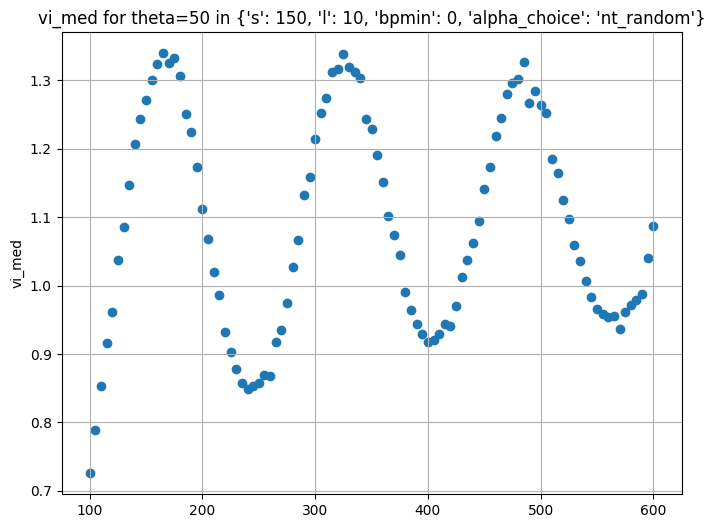

In [57]:
def ncl_cut_1D(df: pl.DataFrame, config: dict, output: str, fx_name: str, fx_value: float, norm_type=None, plot_log2=False) -> tuple[list, list]:
    

    # Proper call of function
    if output not in ["v_mean", "vi_med", "vi_mp", "vf", "wf"]:
        raise ValueError(f"Invalid speed_col: '{output}'")
    if fx_name not in ["mu", "theta"]:
        raise ValueError(f"Invalid fixed_input: '{fx_name}'")
    if norm_type not in ["raw", "norm_mu", "norm_th"]:
        raise ValueError(f"Invalid norm_type: '{norm_type}'")

    # Filtering data corresponding to configuration
    filters = (
        (pl.col("s") == config["s"]) &
        (pl.col("l") == config["l"]) &
        (pl.col("bpmin") == config["bpmin"]) &
        (pl.col("alpha_choice") == config["alpha_choice"])
    )

    # Fixed and non-fixed parameters
    if fx_name == "theta":
        mv_name = "mu"
    else: 
        mv_name = "theta"

    # Getting datas
    df_filtered = df.filter(filters & (pl.col(fx_name) == fx_value))
    x_values = df_filtered[mv_name].to_numpy()
    y_values = df_filtered[output].to_numpy()
    mu_values = df_filtered["mu"].to_numpy()

    # Test
    mu_min = 100
    mu_max = 250
    df_test = df.filter(filters & (pl.col("mu") > mu_min) & (pl.col("mu") < mu_max))
    row_vi_med_max = df_test.filter(pl.col("vi_med") == pl.max("vi_med")) # Max de vi_med pas de vi_med sur mu
    idx_max = row_vi_med_max["mu"].to_numpy()
    print(row_vi_med_max)
    print(idx_max)
    
    # Du coup, le fix parameters ou du moins sa valeur est issue de idx_max : on selectionne la colonne de la heatmap mu = 160
    # On extraie les valeurs telles que mu = 160 pour tous les theta
    # Et ensuite, on conserve ce max, que l'on plot pour chaque configuration aléatoire de (s,l) et on  a notre graph pour observer si rescue ou pas

    # Normalizations
    if norm_type:
        if norm_type == "norm_mu":
            norm = mu_values
        if norm_type == "norm_th":
            alpha_o = df_filtered['alphao'][0]
            alpha_f = df_filtered['alphaf'][0]
            s = df_filtered['s'][0]
            l = df_filtered['l'][0]
            norm = (alpha_o * s + alpha_f * l) / (s + l) * mu_values

    # Normalizing or not
    if output in {'v_mean', 'vi_med', 'vi_mp', 'vf'}:
        y_values = np.array(y_values) / norm
    elif output in {'Cf', 'wf'}:
        pass

    # Getting datas in log2 or not
    if plot_log2:
        y_values = np.log2(np.clip(y_values, 1e-10, None))
    else : 
        y_values = np.array(y_values)

    # Done
    return x_values, y_values

# Parameters
cfg = work_configs[3]
output = "vi_med"
fx_name = "theta"
fx_value = 50
print(f"Working on: {cfg} \nWith: output={output} - fx_name={fx_name} - fx_value={fx_value}")

# Call
x_plot, y_plot = ncl_cut_1D(df=work_df, config=cfg, output=output, fx_name=fx_name, fx_value=fx_value, norm_type="norm_th", plot_log2=False)

# Plot
plt.figure(figsize=(8,6))
plt.title(f"{output} for {fx_name}={fx_value} in {cfg}")
plt.scatter(x_plot, y_plot,marker="o")
plt.ylabel(f"{output}")
plt.grid(True)
plt.show()

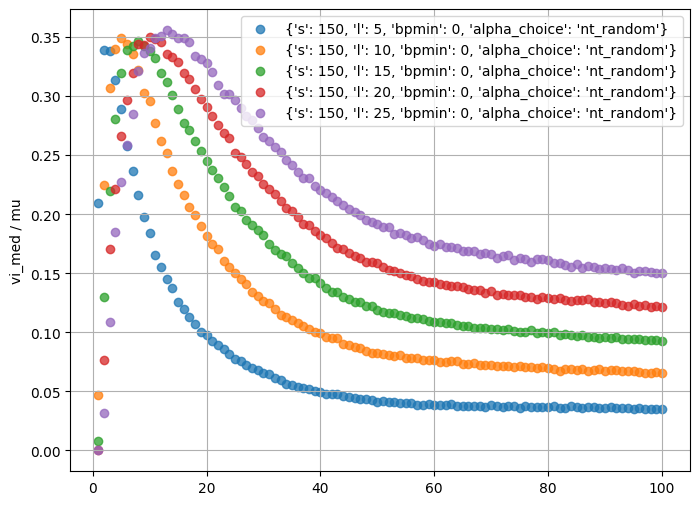

In [48]:
# Attention perte de periodicité au fur et à mesure
# Necessite une detection automatique du point le plus chaud : récupérer son mu_value

output = "vi_med"
fx_name = "mu"
norm_type = "norm_mu"

cfg_2 = work_configs[2]
s2, l2 = 150, 5
fx_value_2 = s2 + l2
x_plot_2, y_plot_2 = ncl_cut_1D(df=work_df, config=cfg_2, output=output, fx_name=fx_name, fx_value=fx_value_2, norm_type=norm_type, plot_log2=False)

cfg_3 = work_configs[3]
s3, l3 = 150, 10
fx_value_3 = s3 + l3
x_plot_3, y_plot_3 = ncl_cut_1D(df=work_df, config=cfg_3, output=output, fx_name=fx_name, fx_value=fx_value_3, norm_type=norm_type, plot_log2=False)

cfg_4 = work_configs[4]
s4, l4 = 150, 15
fx_value_4 = s4 + l4
x_plot_4, y_plot_4 = ncl_cut_1D(df=work_df, config=cfg_4, output=output, fx_name=fx_name, fx_value=fx_value_4, norm_type=norm_type, plot_log2=False)

cfg_5 = work_configs[5]
s5, l5 = 150, 20
fx_value_5 = s5 + l5
x_plot_5, y_plot_5 = ncl_cut_1D(df=work_df, config=cfg_5, output=output, fx_name=fx_name, fx_value=fx_value_5, norm_type=norm_type, plot_log2=False)

cfg_6 = work_configs[6]
s6, l6 = 150, 25
fx_value_6 = s6 + l6
x_plot_6, y_plot_6 = ncl_cut_1D(df=work_df, config=cfg_6, output=output, fx_name=fx_name, fx_value=fx_value_6, norm_type=norm_type, plot_log2=False)

plt.figure(figsize=(8,6))
plt.scatter(x_plot_2, y_plot_2, label=f"{cfg_2}", alpha=0.75)
plt.scatter(x_plot_3, y_plot_3, label=f"{cfg_3}", alpha=0.75)
plt.scatter(x_plot_4, y_plot_4, label=f"{cfg_4}", alpha=0.75)
plt.scatter(x_plot_5, y_plot_5, label=f"{cfg_5}", alpha=0.75)
plt.scatter(x_plot_6, y_plot_6, label=f"{cfg_6}", alpha=0.75)
plt.ylabel("vi_med / mu")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Courbe de valeur maximale de (vi_med / mu) en fonction du point le plus chaud en suivant les configs en fait
# Donc c'est extraire le point maximal pour chaque config 
# Puis tracer ce point maximal en fonction de la config et donc de la taille du linker




# III.1 A reprendre

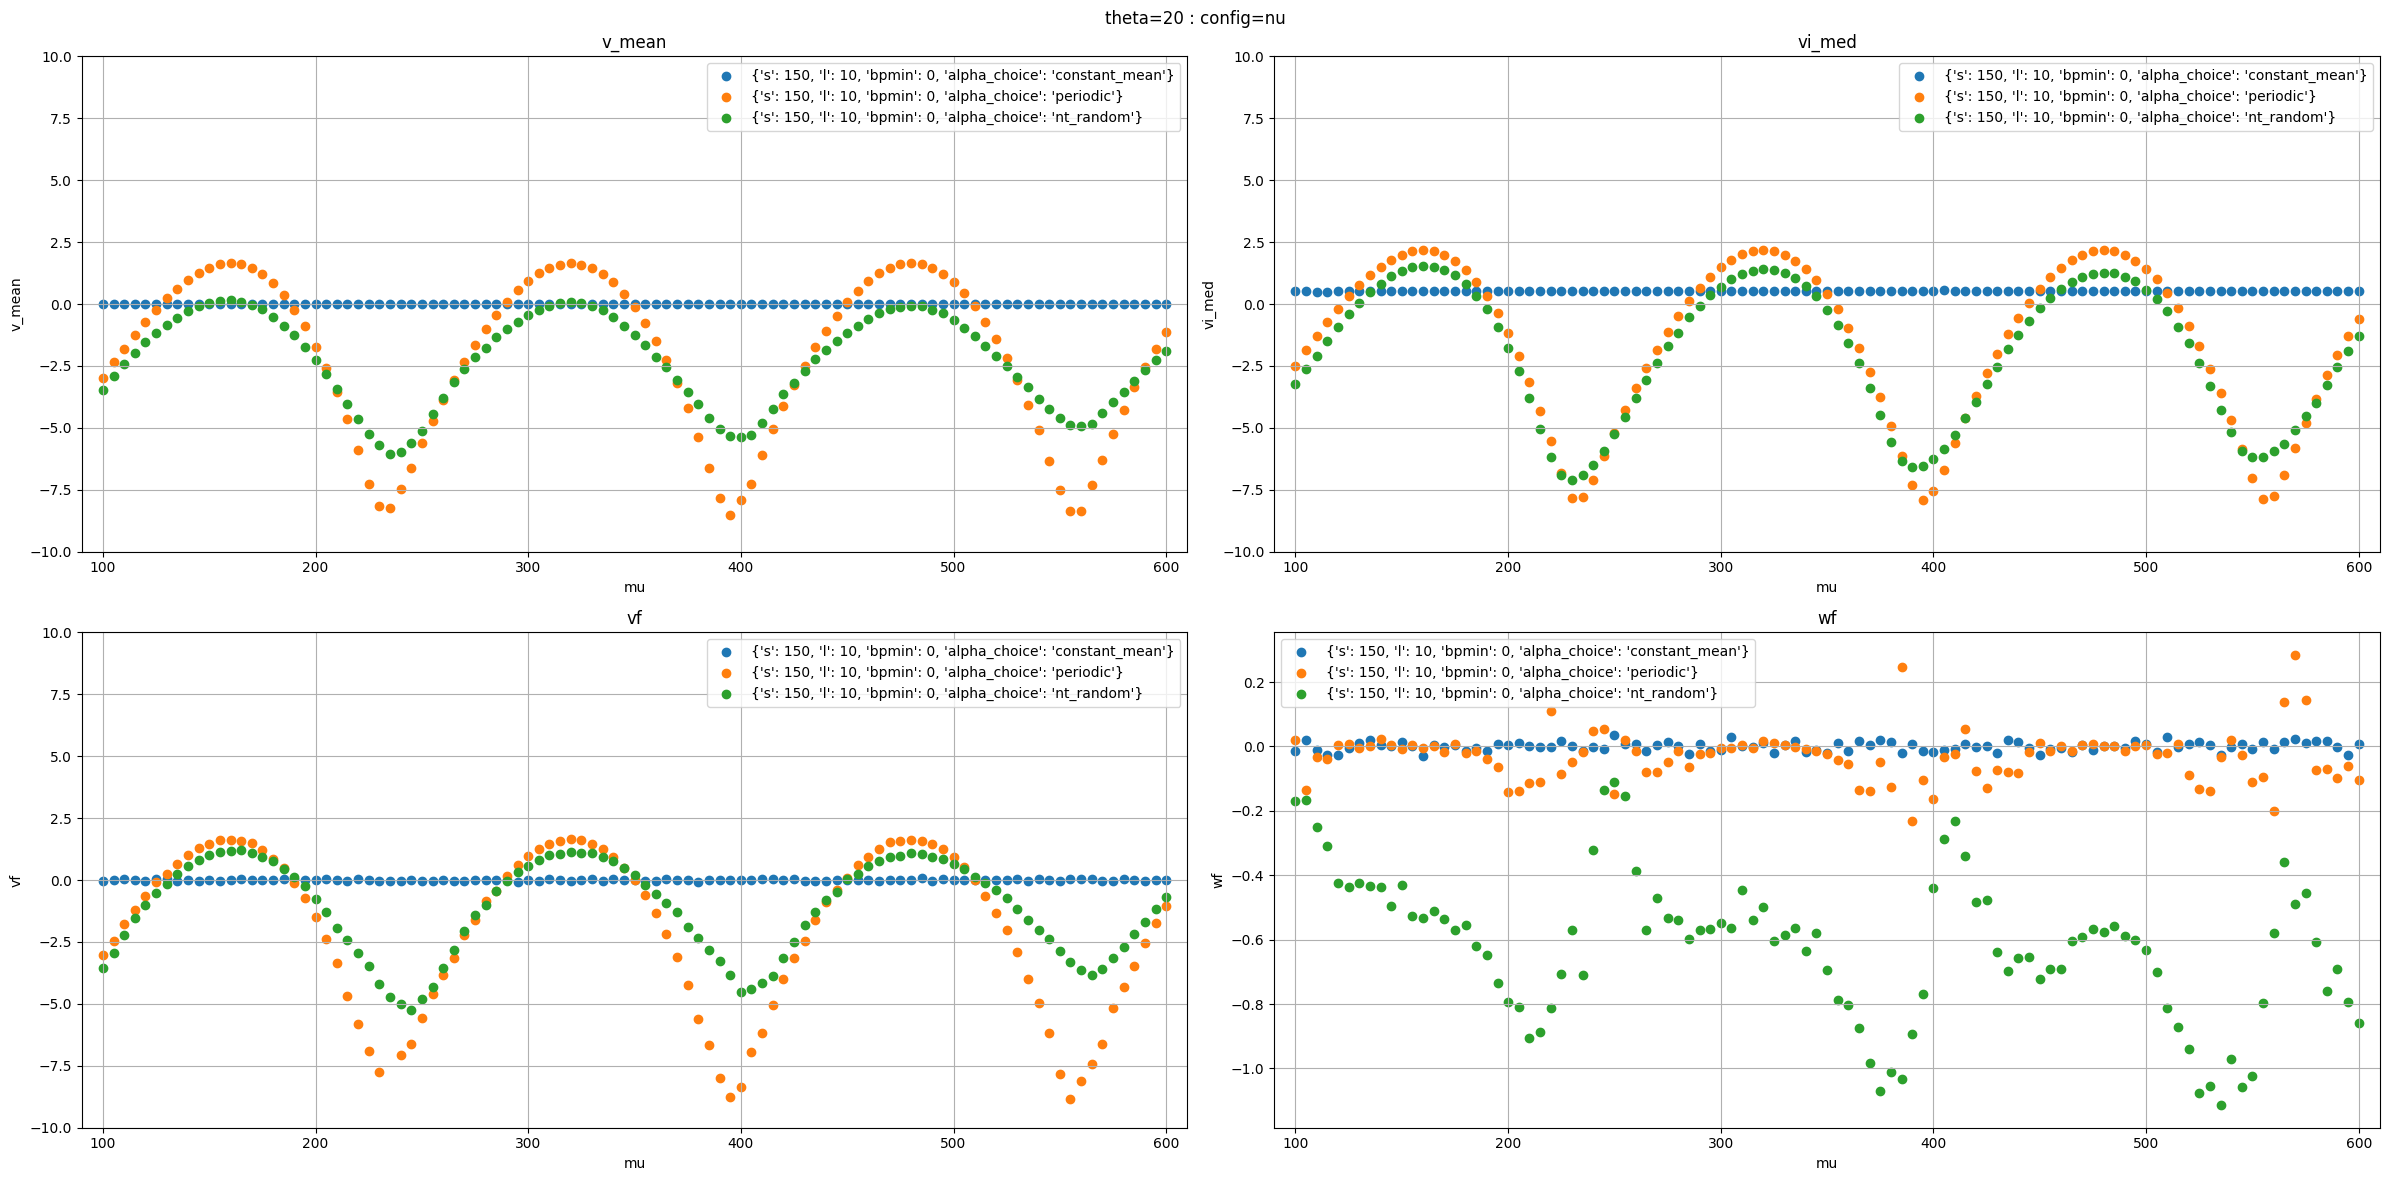

In [66]:
def ncl_multiplot_1D(param: str, param_value: int, config_choice: str):
    """
    Generate a 2x2 multiplot showing different speed-related metrics 
    as a function of the non-fixed parameter, for several configuration sets.

    Args:
        param (str): The name of the fixed parameter. Must be either `'mu'` or `'theta'`.
            This parameter is held constant at `param_value`.
        param_value (int): The fixed value for the `param` parameter.
        config_choice (str): The type of configuration group to use. Must be one of:
            - `'nu'`: selects configurations [0], [1], and [3] from `sorted_combinations_configs`
            - `'ls'`: selects configurations [3:10] plus [2]
            - `'bp'`: selects configurations from index 10 onward

    Raises:
        ValueError: If `param` is not `'mu'` or `'theta'`.
        ValueError: If `config_choice` is not one of `'nu'`, `'ls'`, or `'bp'`.

    Notes:
        - Four metrics are plotted: `"v_mean"`, `"vi_med"`, `"vf"`, and `"wf"`.
        - The x-axis corresponds to the non-fixed parameter (i.e., the one that is not `param`).
        - Each subplot represents one metric, with multiple configurations plotted in each.
        - The `data_1D` function is called to retrieve the (x, y) data for plotting.
        - A global legend and title are added for clarity.

    Example:
        >>> multiplot_1D(param="theta", param_value=25, config_choice="bp")
    """

    # Values to display
    values = ["v_mean", "vi_med", "vf", "wf"]
    n_values = len(values)


    # Fixed parameters
    settings = ["mu", "theta"]
    if param not in settings:
        print('No such param accessible : either mu or theta fixed')
        return None
    if (param == 'mu' and param_value not in np.arange(100,605,5)) or (param == 'theta' and param_value not in np.arange(1, 101, 1)):
        print('Not an accessible value for the parameter : either too low - two high - not binned')
        return None
    nfo = [x for x in settings if x != param][0]

    # Choice of configuration
    if config_choice not in ['nu', 'ls', 'bp']:
        raise ValueError('No such configuration')
    elif config_choice == 'nu':
        config = sorted_combinations_configs[0:2]
        config.append(sorted_combinations_configs[3])
    elif config_choice == 'ls':
        config = sorted_combinations_configs[3:10]
        config.append(sorted_combinations_configs[2])
    elif config_choice == 'bp':
        config = sorted_combinations_configs[10::]


    # Plot initialization
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

    # Loop over each value and config
    for ax, output in zip(axes.flatten(), values):
        for cfg in config:
            mu, v = ncl_data_1D(df=df_pl_main, config=cfg, speed_col=output, fixed_input=param, fixed_value=param_value)
            ax.scatter(mu, v, label=str(cfg), linewidth=1)

        ax.set_title(output)
        ax.set_xlabel(str(nfo))
        ax.set_ylabel(output)
        ax.grid(True, which='both')

        if param == 'theta':
            ax.set_xlim([90,610])
        elif param =='mu':
            ax.set_xlim([-10,110])

        if output in ["v_mean", "vi_med", "vf"]:
            ax.set_ylim([-10, 10])
        ax.legend()


    fig.suptitle(f"{param}={param_value} : config={configuration}")
    plt.tight_layout()
    plt.show()


# Calling function
parameter = 'theta'
parameter_value = 20
configuration = 'nu'
ncl_multiplot_1D(param=parameter, param_value=parameter_value, config_choice=configuration)
# You can call with "config_choice=sorted_combinations_configs" if you want all the results displayed at once

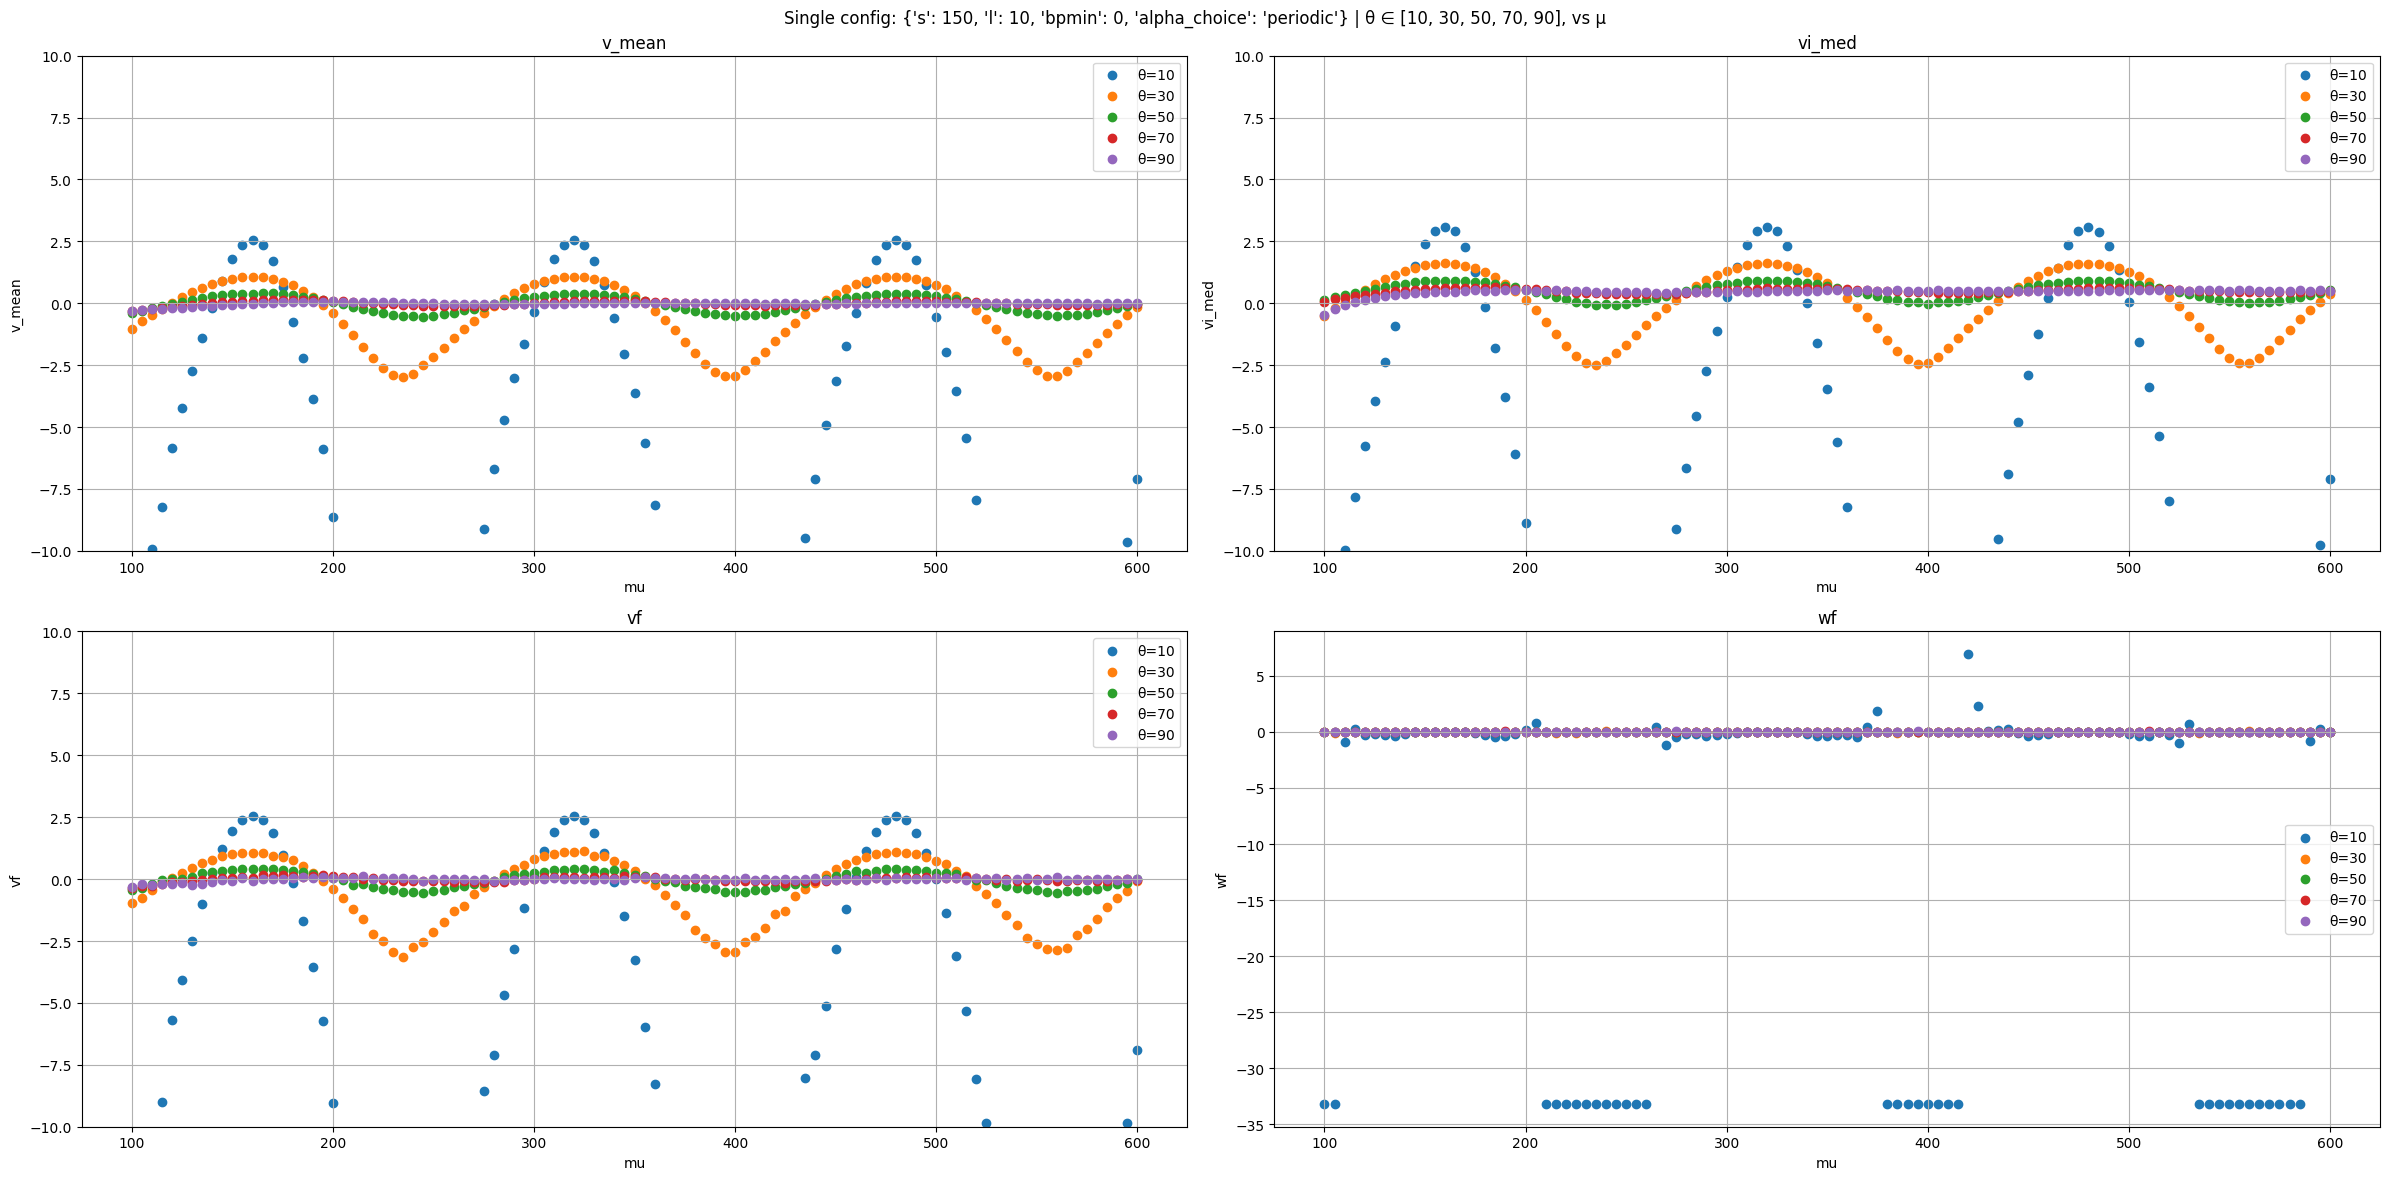

In [65]:
def ncl_multiplot_one_config_few_theta(config: list, theta_values: list = [10, 30, 50, 70, 90]):
    """
    Generate a 2x2 multiplot showing different speed-related metrics as a function of mu,
    for several fixed theta values, using a single configuration.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    metrics = ["v_mean", "vi_med", "vf", "wf"]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

    for ax, metric in zip(axes.flatten(), metrics):
        for theta in theta_values:
            try:
                # This call retrieves all mu for a fixed theta
                mu_vals, y_vals = ncl_data_1D(
                    df=df_pl_main,
                    config=config,
                    speed_col=metric,
                    fixed_input="theta",
                    fixed_value=theta
                )
                if len(mu_vals) == 0 or len(y_vals) == 0:
                    continue
                ax.scatter(x=mu_vals, y=y_vals, label=f"θ={theta}", marker='o')

            except Exception as e:
                print(f"Error at θ={theta} for {metric}: {e}")
                continue
        ax.set_title(metric)
        ax.set_xlabel("mu")
        ax.set_ylabel(metric)
        ax.grid(True, which='both')
        if metric in ["v_mean", "vi_med", "vf"]:
            ax.set_ylim([-10, 10])
        ax.legend()

    fig.suptitle(f"Single config: {config} | θ ∈ {theta_values}, vs μ")
    plt.tight_layout()
    plt.show()



config = sorted_combinations_configs[1]
ncl_multiplot_one_config_few_theta(config=config)


## III.2 3D

In [ ]:
# def ncl_plotly_3D_single_configuration(config_data, speed_cols, plot_log2=True):
#     """
#     Displays interactive 3D scatter plots for a given configuration using Plotly,
#     with custom colorbars and fixed z-axis limits.

#     Parameters
#     ----------
#     config_data : dict
#         Dictionary containing all required data for one configuration.
#     speed_cols : list of str
#         List of keys corresponding to 2D arrays to plot.
#     plot_log2 : bool, optional
#         If True, apply log2 scaling to selected speed columns.
#     """


#     # Getting values
#     mu = config_data["mu_values"]
#     theta = config_data["theta_values"]
#     MU, THETA = np.meshgrid(mu, theta)
#     config = config_data["config"]

#     # Creating the subplot
#     fig = make_subplots(
#         rows=2, cols=2,
#         specs=[[{'type': 'scene'}, {'type': 'scene'}],
#                [{'type': 'scene'}, {'type': 'scene'}]],
#         subplot_titles=[f"{col}" for col in speed_cols],
#         horizontal_spacing=0.08,
#         vertical_spacing=0.1
#     )

#     # Loop for each subplot on each speed_col
#     for idx, speed_col in enumerate(speed_cols):
#         row = idx // 2 + 1
#         col = idx % 2 + 1
#         Z = np.array(config_data[speed_col])

#         # Apply log2 transformation
#         if plot_log2 and speed_col in ["v_mean", "vi_med", "vi_mp", "vf"]:
#             Z_transformed = np.log2(Z + 1e-10)
#             cmin, cmax = -2, 2
#             z_label = f"log₂({speed_col})"
#             tickvals = [-2, -1, 0, 1, 2]
#             ticktext = ["−2", "−1", "0", "1", "2"]

#         # Apply no transformation
#         else:
#             Z_transformed = Z
#             cmin, cmax = 0, 1
#             z_label = speed_col
#             tickvals = [0, 0.25, 0.5, 0.75, 1]
#             ticktext = ["0", "0.25", "0.5", "0.75", "1"]

#         # Positions of subplot for improved lecture
#         if row == 1 and col == 1:
#             cb_x, cb_y = 0.00, 0.82
#         elif row == 1 and col == 2:
#             cb_x, cb_y = 0.48, 0.82
#         elif row == 2 and col == 1:
#             cb_x, cb_y = 0.00, 0.32
#         elif row == 2 and col == 2:
#             cb_x, cb_y = 0.48, 0.32

#         # Plotting each subplot
#         scatter = go.Scatter3d(
#             x=MU.flatten(),
#             y=THETA.flatten(),
#             z=Z_transformed.flatten(),
#             mode='markers',
#             marker=dict(
#                 size=3,
#                 color=Z_transformed.flatten(),
#                 colorscale='thermal',
#                 cmin=cmin,
#                 cmax=cmax,
#                 colorbar=dict(
#                     title=z_label,
#                     x=cb_x,
#                     y=cb_y,
#                     len=0.35,
#                     thickness=14,
#                     tickvals=tickvals,
#                     ticktext=ticktext,
#                     xanchor='left'
#                 )
#             ),
#             name=z_label,
#             showlegend=False
#         )

#         # Adding the layout for the subplot
#         fig.add_trace(scatter, row=row, col=col)
#         fig.update_scenes(
#             dict(
#                 xaxis_title="mu",
#                 yaxis_title="theta",
#                 zaxis_title=z_label,
#                 zaxis=dict(range=[cmin, cmax])
#             ),
#             row=row,
#             col=col
#         )

#     # Last actions
#     fig.update_layout(
#         title=f"Config: {config['alpha_choice']} — s={config['s']}, l={config['l']}, bpmin={config['bpmin']}",
#         height=1200,
#         width=1600,
#         margin=dict(t=100, r=50, l=50)
#     )

#     # End 
#     fig.show()
#     return None


# # Choosing config
# config = sorted_combinations_configs[3]
# print(f'Studied configuration : {config}')

# # Finding config
# for key, data in loaded_data.items():
#     if data["config"] == config:
#         config_studied = data
#         break
# else:
#     raise ValueError("Configuration not found in loaded_data")

# # Plotting config
# ncl_plotly_3D_single_configuration(
#     config_studied,
#     ["v_mean", "vi_med", "vf", "wf"],
#     plot_log2=True
# )

In [ ]:
# import numpy as np
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# def ncl_plotly_3D_compare_two_configs(
#     config1_or_data,
#     config2_or_data,
#     metric="vi_med",
#     plot_log2=True,
#     title=None,
#     loaded_data=None,
# ):
#     """
#     Compare deux configurations sur un seul indicateur avec 2 sous-graphiques 3D.

#     - config*_or_data peut être :
#         (A) un dict de données complet (avec 'mu_values', 'theta_values', metric, 'config')
#         (B) un dict de configuration (ex. issu de sorted_combinations_configs[*])
#             => dans ce cas, 'loaded_data' doit être fourni pour retrouver les données.

#     Parameters
#     ----------
#     config1_or_data, config2_or_data : dict
#     metric : str
#     plot_log2 : bool
#     title : str | None
#     loaded_data : dict | None
#         Mapping quelconque -> dict de données (contenant 'config').
#     """

#     def _resolve_to_data(obj):
#         # cas (A) : déjà un dict de données
#         if isinstance(obj, dict) and "mu_values" in obj and "theta_values" in obj and metric in obj:
#             return obj

#         # cas (B) : c’est une config -> on cherche dans loaded_data
#         if loaded_data is None:
#             raise ValueError(
#                 "You passed a config (no 'mu_values' inside). Provide 'loaded_data' to resolve it."
#             )
#         for _, data in loaded_data.items():
#             if data.get("config") == obj:
#                 # trouvé
#                 if not all(k in data for k in ("mu_values", "theta_values", metric)):
#                     raise KeyError(
#                         f"Resolved data missing one of required keys: 'mu_values', 'theta_values', '{metric}'."
#                     )
#                 return data
#         raise KeyError("Configuration not found in loaded_data.")

#     data1 = _resolve_to_data(config1_or_data)
#     data2 = _resolve_to_data(config2_or_data)

#     def _prep(data):
#         mu = data["mu_values"]
#         th = data["theta_values"]
#         MU, TH = np.meshgrid(mu, th)
#         Z = np.asarray(data[metric], dtype=float)

#         if plot_log2:
#             Zt = np.log2(Z + 1e-10)
#             z_label = f"log₂({metric})"
#             ticks = dict(vals=[-2, -1, 0, 1, 2], text=["−2", "−1", "0", "1", "2"])
#         else:
#             Zt = Z
#             z_label = metric
#             ticks = dict(vals=None, text=None)
#         return MU, TH, Zt, z_label, ticks

#     MU1, TH1, Z1, z_label, t1 = _prep(data1)
#     MU2, TH2, Z2, _,      t2 = _prep(data2)

#     # bornes z communes pour comparaison honnête
#     if plot_log2:
#         zmin, zmax = -2, 2
#     else:
#         zmin = np.nanmin([np.nanmin(Z1), np.nanmin(Z2)])
#         zmax = np.nanmax([np.nanmax(Z1), np.nanmax(Z2)])
#         if not np.isfinite(zmin) or not np.isfinite(zmax) or zmin == zmax:
#             zmin, zmax = 0.0, 1.0

#     # titres individuels
#     c1 = data1["config"]; c2 = data2["config"]
#     t1_str = f"{c1['alpha_choice']} — s={c1['s']}, l={c1['l']}, bpmin={c1['bpmin']}"
#     t2_str = f"{c2['alpha_choice']} — s={c2['s']}, l={c2['l']}, bpmin={c2['bpmin']}"

#     fig = make_subplots(
#         rows=1, cols=2,
#         specs=[[{"type": "scene"}, {"type": "scene"}]],
#         subplot_titles=[t1_str, t2_str],
#         horizontal_spacing=0.08
#     )

#     fig.add_trace(
#         go.Scatter3d(
#             x=MU1.ravel(), y=TH1.ravel(), z=Z1.ravel(),
#             mode="markers",
#             marker=dict(
#                 size=3,
#                 color=Z1.ravel(),
#                 colorscale="thermal",
#                 cmin=zmin, cmax=zmax,
#                 colorbar=dict(title=z_label, x=0.44, y=0.85, len=0.8, thickness=14,
#                               xanchor="right", tickvals=t1["vals"], ticktext=t1["text"])
#             ),
#             showlegend=False,
#             name=f"{z_label} cfg1"
#         ), row=1, col=1
#     )

#     fig.add_trace(
#         go.Scatter3d(
#             x=MU2.ravel(), y=TH2.ravel(), z=Z2.ravel(),
#             mode="markers",
#             marker=dict(
#                 size=3,
#                 color=Z2.ravel(),
#                 colorscale="thermal",
#                 cmin=zmin, cmax=zmax,
#                 colorbar=dict(title=z_label, x=1.02, y=0.85, len=0.8, thickness=14,
#                               xanchor="left", tickvals=t2["vals"], ticktext=t2["text"])
#             ),
#             showlegend=False,
#             name=f"{z_label} cfg2"
#         ), row=1, col=2
#     )

#     for col in (1, 2):
#         fig.update_scenes(
#             dict(
#                 xaxis_title="mu",
#                 yaxis_title="theta",
#                 zaxis_title=z_label,
#                 zaxis=dict(range=[zmin, zmax])
#             ),
#             row=1, col=col
#         )

#     if title is None:
#         title = f"Comparison on {metric} — cfg1 vs cfg2"

#     fig.update_layout(title=title, height=650, width=1400, margin=dict(t=80, r=40, l=40, b=20))
#     fig.show()
#     return None


# cfg1 = sorted_combinations_configs[1]
# cfg2 = sorted_combinations_configs[2]

# ncl_plotly_3D_compare_two_configs(
#     cfg1, cfg2,
#     metric="vi_med",
#     plot_log2=True,
#     loaded_data=loaded_data  # nécessaire pour résoudre en dicts de données
# )



# .